# Immersive Economy business analysis

This notebook analyses the Immersive business datasets including the MTM survey dataset and the GlassAI data.

We follow the structure that we proposed in our meeting with IUK/KTN and which we are implementing in the findings slide-deck:

1. Approach and definition
  * We need to define segments of the IE economy using the survey questions.
  * We will look at their distribution by role in the value chain / size
2. Measuring the sector
  * This will primarily be based on Kostas predictive analysis
3. Mapping its clusters
  * Here we will use GlassAI and MTM to identify clusters of activity by category and sector
4. Explaining its drivers and barriers
  * Analysis of business models etc.
5. Tracking its support
  * Here we focus on survey responses. Kostas is doing analysis based on the GtR/H2020 data.
6. Conclusions and next steps


## Preliminaries

Such as paths

In [1186]:
%matplotlib inline
#NB I install a standard set of directories

#Get the top path
top_path = os.path.dirname(os.getcwd())

#Create the path for external data
ext_data = os.path.join(top_path,'data/external')

#And external data
proc_data = os.path.join(top_path,'data/processed')

fig_path = os.path.join(top_path,'reports/figures')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

And functions

In [352]:
# Functions
def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

def save_fig(name):
    plt.tight_layout()
    plt.savefig(fig_path+'/{date}_{name}.pdf'.format(date=today_str,name=name),bbox_inches='tight')


## 1. Load data

In [930]:
#This loads all the immersive data (Glass AI and immersive data which we previously processed)

with open(proc_data+'/4_3_2018_immersive_dataset.p','rb') as infile:
    immersive = pickle.load(infile)

glai = immersive[0]
mtm_input = immersive[1]

In [931]:
#Data provided by Kostas for testing

#Removing missing values
fame = pd.read_csv(ext_data+'/fame_data.csv',na_values='n.a.')

fame.dropna(axis=0,subset=['Number of employees\nLast avail. yr','Organization ID'],inplace=True)
#Change employment variables to something more tractable

#Rename awkward column names
fame.rename(columns={'Number of employees\nLast avail. yr':'employment_actual',
                    'Operating revenue (TO)\nth GBP\nLast avail. yr':'turnover_actual'},inplace=True)

#Turn turnover into £ instead of £K
fame['turnover_actual'] = fame['turnover_actual']*1000

#Turn into a dict where the keys are the org ids
fame_dict = {x['Organization ID']:x for x in fame.to_dict(orient='records')}

In [932]:
# IDBR totals for normalising
idbr = pd.read_csv(ext_data+'/idbr_business_totals.csv')

## Analysis.

### 1. Approach and definition

In [933]:
from itertools import product

from sklearn.cluster import hierarchical
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import pairwise_distances

In [934]:
#Some functions for cluster analysis

def draw_heatmap(obs,distance,ax,title):
    '''
    This function draws a heatmap where each cell represents the similarity between variables
    We are actually feeding it a df where the rows are observations and the variables are features used to cluster
    them
    
    '''
    #Estimate distances
    dist = pairwise_distances(np.array(obs),metric=distance)
    
    cols = obs.index
    
    #Draw it
    mappable = ax.imshow(dist,aspect='auto',cmap='seismic')
    
    #Add the labels and title
    #y ticks and labels
    ax.set_yticks(np.arange(len(cols)))
    ax.set_yticklabels(cols)
    

    #x ticks and labels
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels(cols,rotation=90)
   
    #Title
    ax.set_title(title)
    
    fig.colorbar(mappable,ax=ax)
    
    
def draw_dendrogram(obs,distance,ax,title):
    '''
    Takes observations, estimates distances and performs agglomerative clustering.
    It draws a dendrogram showing the clusters in the data
    
    
    '''
    
    #Estimate distances
    dist = pairwise_distances(np.array(obs),metric=distance)
    
    cols = obs.index
    
    

    hierarchy.dendrogram(hierarchy.linkage(dist),ax=ax)


    ax.set_xticklabels([cols[int(x.get_text())] for x in ax.get_xticklabels()],rotation=90)
    
    ax.set_title(title)
    
def classify_orgs(data,categories,how='binary'):
    '''
    This function produces a new variable with some information abouut what
    an immersive company does, based on responses to other questions (categories) in the survey.
    The 'how' determines if we create a dummy or an index 

    '''
    if how=='binary':
        cat = [1 if any(x==1 for x in list(data.loc[x,categories])) else 0 for x in np.arange(len(data))]
    else:
        cat = [np.sum(list(data.loc[x,categories])) for x in np.arange(len(data))]
        
    return(cat)

In [935]:
#We create a copy of MTM which we will modify
mtm = mtm_input.copy()

In [936]:
#The variable function shows the % of turnover generated by immersive tech in the sample
#Let's create 3 categories

#We create a placeholder for the external name. Not sure about what to call them!
external_name = 'allied'

#We sort companies in 3 buckets
mtm['function'] = ['specialist' if x in ['51-75%','100%','76-99%'] else 'participant' if x in 
                  ['0-10%','11-25%','26-50%'] else external_name if x=='None' else np.nan for x in mtm.q21_immersive_turnover]

#Create a company size variable
mtm['comp_size'] = ['micro' if x in ['0','1-2','3-5','6-10'] else 'small' if x in ['11-25','26-50']
                else 'medium' if x in ['51-100','101-250'] else 'large' if x=='251+' else np.nan for x in
                mtm.q16_employees]

#This is what the positions in the value chain look like
100*mtm.function.value_counts(normalize=True)

participant    43.939394
specialist     41.666667
allied         14.393939
Name: function, dtype: float64

In [937]:
def boring_barchart(table,title,ylabel,ax):
    '''
    Plots a boring barchart
    
    '''
    
    table.plot.bar(color='orange',edgecolor=['black']*len(table),ax=ax)

    ax.set_ylabel(ylabel,size=14)
    ax.set_xticklabels([x.capitalize() for x in table.index],size=14,rotation=45,ha='right')
    ax.set_title(title,size=16)

def boring_crosstab(table,title,ylabel,ax):
    '''
    Plots a boring crosstab
    
    '''
    
    table.plot.bar(edgecolor=['black']*len(table),ax=ax)

    ax.set_ylabel(ylabel,size=14)
    ax.set_xticklabels([x.capitalize() for x in table.index],size=14,rotation=45,ha='right')
    ax.set_title(title,size=16)

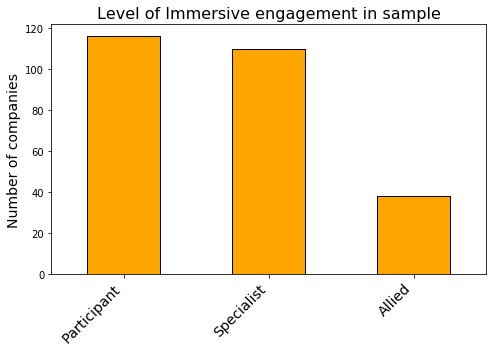

In [938]:
#Plot them

fig,ax = plt.subplots(figsize=(7,5))

boring_barchart(mtm.function.value_counts(),'Level of Immersive engagement in sample',
               'Number of companies',ax)

save_fig('immersive_engagement')

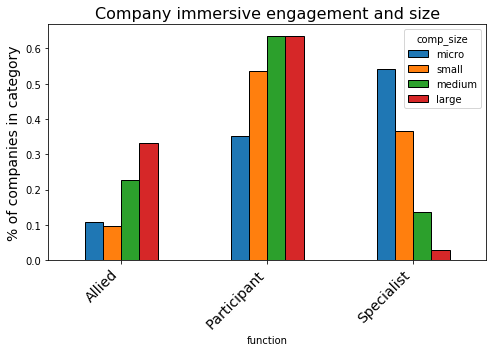

In [939]:
comp_size_order = ['micro','small','medium','large']


size_ct = pd.crosstab(mtm.comp_size,mtm.function,normalize=0).sort_values(
    'specialist',ascending=False).loc[comp_size_order]


fig,ax = plt.subplots(figsize=(7,5))

boring_crosstab(size_ct.T,'Company immersive engagement and size','% of companies in category',ax=ax)

save_fig('engagement_size')


In [940]:
#What is the large company here?
mtm.loc[(mtm.function=='specialist') & (mtm.comp_size=='large')]

,id,orgname,q2_3_postcode,q2_4_email,q3_market_role_vr_techdev,q3_market_role_ar_techdev,q3_market_role_other_ie_techdev,q3_market_role_vr_content,q3_market_role_ar_content,q3_market_role_other_ie_content,...,q3_role_other,clean_postcode,pcds,ttwa,gor,ttwa_name,reg_nat,domain,function,comp_size
265,3624802,HTC Vive ...,SL11YP,paul_brown@htc.com ...,Yes,No,No,Yes,No,No,...,No,SL 11YP,NaN,NaN,NaN,NaN,NaN,htc.com,specialist,large


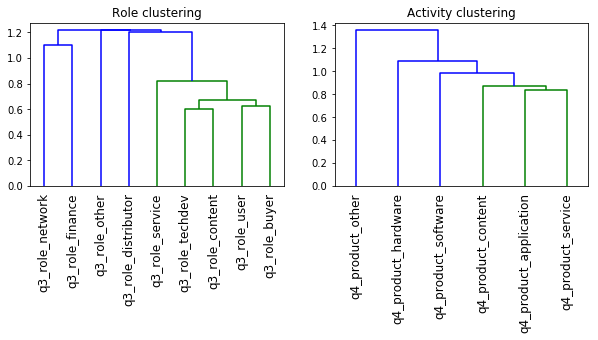

In [941]:
#Now we need to allocate companies to their role
#We use the product variable, which tells what kind of activity a company focuses on
role = mtm.loc[:,['q3_role_' in x for x in mtm.columns]].applymap(lambda x: 0 if x =='No' else 1 if type(x)==str else x)
product= mtm.loc[:,['q4' in x for x in mtm.columns]].applymap(lambda x: 0 if x =='No' else 1 if type(x)==str else x)

fig,ax=plt.subplots(ncols=2,figsize=(10,3))

draw_dendrogram(role.dropna().T,'jaccard',ax=ax[0],title='Role clustering')
draw_dendrogram(product.dropna().T,'jaccard',ax=ax[1],title='Activity clustering')

In [942]:

#Number of companies with more than one role
np.sum(role.sum(axis=1)>1)/len(role)
#np.sum(product.sum(axis=1)>1)/len(role)

0.8447653429602888

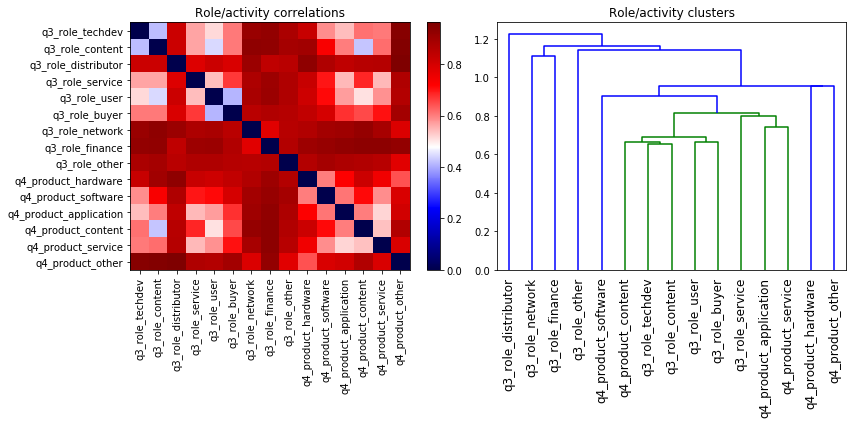

In [943]:
fig,ax=plt.subplots(figsize=(12,6),ncols=2)

combined_roles = pd.concat([role,product],axis=1)

draw_heatmap(combined_roles.T,'jaccard',ax=ax[0],title='Role/activity correlations')
draw_dendrogram(combined_roles.T,'jaccard',ax=ax[1],title='Role/activity clusters')

plt.tight_layout()

save_fig('clustering')

In [944]:
#We use answers to 5 to classify respondents into 
#We ignore the 'user' category because it just makes the data too messy

#These are developers of technology or software
dev = classify_orgs(combined_roles,['q4_product_software',
                             'q4_product_hardware',
                             'q3_role_techdev'
                            ],how='sum')

#These are creators of content
content = classify_orgs(combined_roles,['q4_product_content',
                                 'q3_role_content',
                                        #'q3_role_techdev'
                                 #'q4_product_application'
                                ],how='sum')

#These apply Immersive tech.
applier = classify_orgs(combined_roles,['q3_role_service','q4_product_service',
                     'q4_product_application'],how='sum')

#These enable the use of immersive technology by providing access to finance,distribution, services etc
enabler = classify_orgs(combined_roles,['q3_role_network','q3_role_service',
                     'q3_role_finance',
                     'q3_role_distributor'],how='sum')

#These buy immersive tech
buyer = classify_orgs(combined_roles,['q3_role_buyer',
                           ],how='sum')


mtm['classification'] = pd.DataFrame({'creator':content,'developer':dev,'enabler':enabler,'buyer':buyer,
                                     'applier':applier}).idxmax(axis=1)

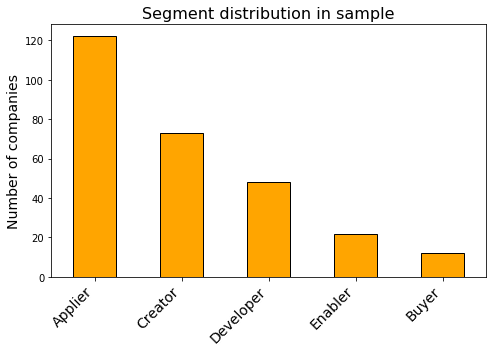

In [945]:
#Plot them

fig,ax = plt.subplots(figsize=(7,5))

boring_barchart(mtm.classification.value_counts(),'Segment distribution in sample',
               'Number of companies',ax)

save_fig('company_segment')

In [946]:
joined = pd.merge(glai,mtm,left_on='domain',right_on='domain',how='inner')

for x in set(mtm['classification']):
    print(x)
    print('\n')
    
    data = joined.loc[joined.classification==x,'Description']
    
    for x in data[-5:]:
        print(x[:250])
        print('\n')

buyer


For more than a century, Babcock has been trusted to deliver bespoke, highly-skilled engineering support.

Underpinned by a deep understanding of technology integration, infrastructure management, and specialist training, we help customers around the


Goldsmiths, University of London, is a public research university in London, England, specialising in the arts, design, humanities, and social sciences. It is a constituent college of the University of London. It was founded in 1891 as Goldsmiths' Te


McAvoy provides quality solutions to clients using 
off-site modular construction technology.


The McLaren Group is a British conglomerate based in Woking, Surrey, United Kingdom. Founded by Ron Dennis shortly after his acquisition of the McLaren Formula One team in 1981, it was originally named the TAG McLaren Group due to a partnership with 


Queen Mary University of London is a public research university in London, England, and a constituent college of the federal University o

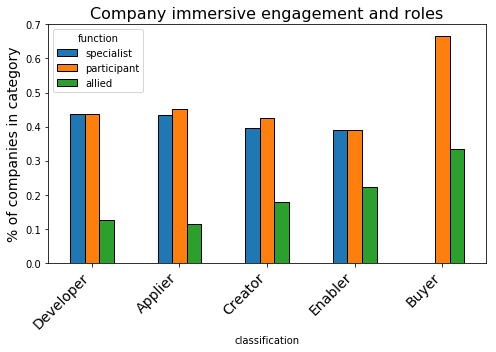

In [947]:
fig,ax = plt.subplots(figsize=(7,5))

role_spec_ct = pd.crosstab(
    mtm['classification'],mtm['function'],normalize=0).sort_values(
    'specialist',ascending=False)[['specialist','participant','allied']]


boring_crosstab(role_spec_ct,'Company immersive engagement and roles','% of companies in category',ax=ax)

save_fig('role_engagement')

In [948]:
#Extract the role order - we can use this in future charts
role_order = pd.crosstab(
    mtm['classification'],mtm['function'],normalize=0).sort_values(
    'specialist',ascending=False).index

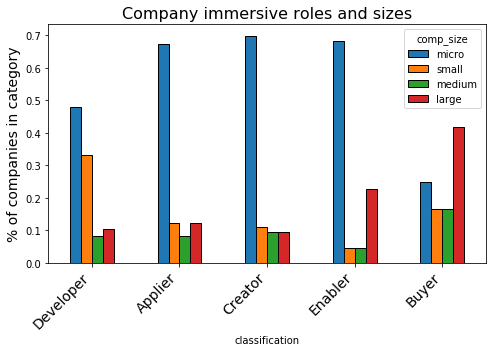

In [949]:
#Roles and sizes

fig,ax = plt.subplots(figsize=(7,5))

role_size_ct = pd.crosstab(
    mtm['classification'],mtm['comp_size'],normalize=0).loc[role_order,comp_size_order]

boring_crosstab(role_size_ct,'Company immersive roles and sizes','% of companies in category',ax=ax)

save_fig('role_size')

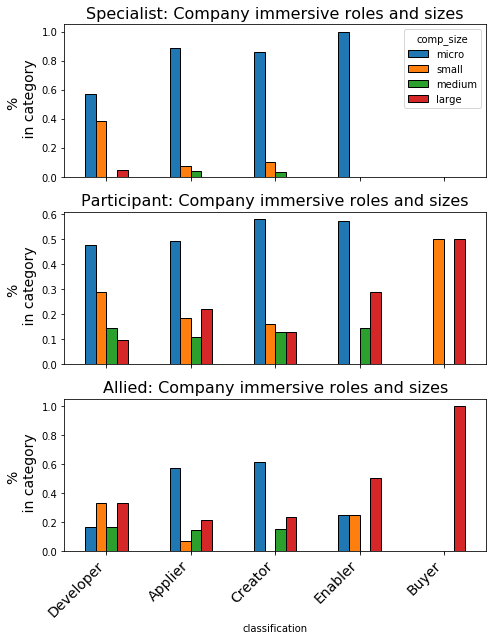

In [950]:
fig,ax = plt.subplots(figsize=(7,9),nrows=3,sharex=True)

for num,x in enumerate(['specialist','participant','allied']):
    data = mtm.loc[mtm.function==x]
    
    role_size_ct_tmp = pd.crosstab(
        data['classification'],
        data['comp_size'],normalize=0).loc[role_order,comp_size_order]

    boring_crosstab(role_size_ct_tmp,'{comp_type}: Company immersive roles and sizes'.format(comp_type=x.capitalize()),
                    '% \n in category',ax=ax[num])
    
    if num>0:
        ax[num].legend().set_visible(False)
    
plt.tight_layout()

save_fig('role_size_engagement')

## 2. Economic impact

**Steps**
* Produce a modelling dataset
* Model size and level of immersive engagement
* Generate mid-point estimates for turnover and employment taking into account the distribution of survey responses
* Here we should replace these estimates with the real data if those data are available
* Estimate results

**Observation**
* For the purposes of estimation it is a good idea to run the analysis multiple times and average. What would this look like? Just create a pipeline that trains the models 500 times, generates a prediction and its average?
* It also chooses the most likely prediction for each variable



In [374]:
#Load all the sklearn packages

from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score 

import string as st
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, PunktSentenceTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer

#Functions

def comp_sentence(sentence):
    '''
    Takes a sentence and pre-processes it.
    The output is the sentence as a bag of words
    
    '''
    #Remove numbers
    text_no_numbers = re.sub('|'.join([x for x in st.digits]),'',sentence)
    
    #Tokenise
    text_punctuation = tokenizer.tokenize(text_no_numbers)
    
    #Lowercase
    text_lowered = [token.lower() for token in text_punctuation]
        
    #Remove stop words, single letters
    text_stopped = [w for w in text_lowered if w not in stop_words and
                   len(w)>1]
    
    #Stem
    #text_stemmed = [stemmer.stem(w) for w in text_stopped]
    return(text_stopped)
    
    #Output
    
#These are some of the functions used in the comp_sentence (in case I need to use it later)

#Stop words to remove
stop_words = set(stopwords.words("english"))

#Lemmatise
lemmatizer = WordNetLemmatizer()

#Punctu
punctuation = set(st.punctuation) 
stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
snowball = SnowballStemmer("english")


In [679]:
#Load economic data
econ_data = pd.merge(pd.read_csv(proc_data+'/immerse_data_predicted_v2.csv'),
                     glai[['Organization ID','ttwa_name','reg_name']],left_on='Organization ID',right_on='Organization ID')

In [680]:
#Extract incorporation year and age
econ_data['inc_year'] = [int(x.split("-")[0]) for x in econ_data.date_of_creation]
econ_data['age'] = [2018-int(x.split("-")[0]) for x in econ_data.date_of_creation]

In [681]:
#Identify meta-variables
meta_variables = ['index','Company Name','Organization ID','Description','Sector','Sub-sector',
                  '#People','#PeopleWithRole','#PeopleWithBio','#JobListing','#OutNetwork',
                 '#InNetwork','#SourcePages','Website','age','reg_name','ttwa_name','inc_year']

#Subset economic data with right variable
econ_data = econ_data.loc[:,meta_variables].drop_duplicates('Website').reset_index(drop=True)

In [682]:
#Tokenise and process descriptions for some simple NLP analysis
tokens = [comp_sentence(x) if type(x)==str else [] for x in econ_data.Description]

#Focus on the top 40 tokens
top_tokens = pd.Series([x for el in tokens for x in el]).value_counts().sort_values(ascending=False)

#Get the top 40 tokens and turn them into counters
tokens_counted = [{w:np.sum([x==w for x in t]) for w in set(t) if w in top_tokens.index[:40]} for t in tokens]

tokens_counted_df = pd.DataFrame(tokens_counted).fillna(0)

econ_data = pd.concat([econ_data,tokens_counted_df],axis=1)


#Match on web domain and remove duplicated
training_set =pd.merge(econ_data,mtm.loc[:,['comp_size','comp_size_turnover','q16_employees','q21_immersive_turnover',
                                            'q19_turnover','domain','orgname','function']],
                       left_on='Website',
                       right_on='domain').drop_duplicates('domain')

training_set.shape

(116, 66)

In [469]:
#Create turnover categories
#training_set.turnover_cats = 

turnover_size_lookup = {
    'Under Â£50k':'micro',
    'Between Â£100k and Â£500k':'micro',
    'Between Â£10m and Â£25m':'medium',
    'Between Â£1m and Â£5m':'small',
    'Between Â£500k and Â£1m':'micro',
    'Between Â£5m and Â£10m':'small',
    'Over Â£25m':'large',
    'Pre-revenue':'None',
    'Between Â£50k and Â£100k':'micro',
    'Prefer not to say':np.nan,
    np.nan:np.nan   
}

training_set['comp_size_turnover'] = [turnover_size_lookup[x] for x in training_set.q19_turnover]

### Automate modelling

Create a class that takes the predictors and the targets and...

1. Trains models on the training data. This involves:

* Fitting an employment model
* Fitting a turnover model (using employment as a predictor)
* Fitting an engagement model

2. Produces estimates of employment and turnover

While doing this, replaces estimates for variables where we obtained data from FAME.

3. Generates estimates of employment and turnover in the specialist and participant classes.

We do the above 500 times and export averages.

We also export the most voted class for the variables above and use that during the rest of the analysis





In [382]:
class modelImmersiveSize():
    '''
    This class does the following things:
    * Takes the training set, the complete dataset and actual data for larger companies
    * It trains a model on the complete dataset and uses it to predict labels in the complete dataset
    * It replaces data for those companies we identified in FAME
    * Does all the above 500 times and returns average estimates for employment and turnover in specialist and
    participating classes.
    * It returns the most probable label for each company
    
    '''
    
    def __init__(self, training_set,all_set,fame_data):
        '''
        Initialises the data with the input variables
        
        '''
        
        self.training = training_set
        self.all_set = all_set
        self.fame_data = fame_data
        
    
    def predict_variables(self,num_iterations):
        '''
        
        Trains and predicts the model a num_iterations of times.
        Returns a vector with predicted employment and turnover for all company types and
        a df with the class with the most predictions
        
        '''
        
        #Stages
        #1. Predict employment
        #2. Predict turnover (need to think if / how I include predicted employment as a predictor here)
        #3. Predict engagement
        #4. Use all this to generate predicted targets and estimates which are appended to a container
        #5. Return summaries and the values used later
        
        
        #Load the right attributes
        
        training = self.training
        all_set = self.all_set
        fame_data = self.fame_data
        
        #Container with predictions
        cont_predictions = []
        cont_estimates = []
                
        for x in np.arange(num_iterations):
            
            #Keep track of progress
            if x % 5==0:
                print(x)
            
            #Each of the outptus below is a vector with predicted or actual values for all organisations
            #Depending whether they participated on the survey or not
            
            #We predict employment
            pred_empl = predict_financial(training,'comp_size',all_set)
            
            #We predict function
            pred_funct = predict_financial(training,'function',all_set)
            
            #To predict turnover, we also include the predicted employment as a feature
            
            #Get the predicted employment
            empl_input = pred_empl.idxmax(axis=1)
            empl_input.name='employment_pred'
            
            #Combine it with the training and all set (here I am using the inner join to only keep the right 
            #orgs in each set
            training_turn = training.set_index('Organization ID').join(empl_input,how='left').reset_index(drop=False)
            all_set_turn = all_set.set_index('Organization ID').join(empl_input,how='left').reset_index(drop=False)
            
            
            #Combine it with the training and all set (here I am using the inner join to only keep the right 
            #orgs in each set
            #training_turn = pd.concat([training,empl_input],axis=1,join='inner')
            #all_set_turn = pd.concat([all_set,empl_input],axis=1,join='inner')
            
            #Predict!
            #return(training_turn,all_set_turn)
            
            pred_turn = predict_financial(training_turn,'comp_size_turnover',all_set_turn)
            
            #Combine
            preds = [pred_empl,pred_turn,pred_funct]
            
            #preds = [predict_financial(training,target,all_set) for target in ['comp_size',
            #                                                                  'comp_size_turnover',
            #                                                                  'function']] 
            
            #This function returns a variable with estimates
            estimates = generate_estimates(preds)
            
            #Append to the containers
            cont_predictions.append(preds)
            cont_estimates.append(estimates[['turn_estimate','emp_estimate','engagement']])
         
        #Store the estimates
        ests_emp = pd.concat([x.groupby('engagement')['emp_estimate'].sum() for x in cont_estimates],axis=1)
        ests_turn = pd.concat([x.groupby('engagement')['turn_estimate'].sum() for x in cont_estimates],axis=1)
                                
        

        self.ests_emp = ests_emp
        self.ests_turn = ests_turn
        
        #Otput the mean predicted sizes based on all the models
        mean_estimates = pd.concat([pd.concat([x[var] for x in cont_estimates],axis=1).mean(axis=1) for var in 
                                    ['emp_estimate','turn_estimate']],axis=1)
        
        mean_estimates.columns = ['emp_estimate','turn_estimate']
        
        self.mean_estimates = mean_estimates
        
        
        #We also want to store the predictions. We will select for each observation the 
        #prediction with the highest probability
        
        #We go through each element in the stored predictions (first one is employment, second turnover 
        #and third employment)
        
        predicted_labels = pd.concat(
            [predict_top_category([x[val] for x in cont_predictions]) for val in [0,1,2]],axis=1)
        
        predicted_labels.columns = ['employment_label','turnover_label','engagement_label']
        
        self.predicted_labels = predicted_labels
        
        
        #And finally an enriched dataset!
            
        enriched_data = pd.concat([econ_data.set_index('Organization ID'),mean_estimates,predicted_labels],
                                  axis=1)
        
        self.output_data = enriched_data
            
        
            

In [390]:
def generate_estimates(pred_list):
    '''
    This function takes a list with 3 arrays with predictions (employment, turnover and engagement) and
    returns financial (?)
    
    '''
    #Concatenates all the predictions
    all_predictions = pd.concat([prediction.idxmax(axis=1) for prediction in pred_list],axis=1)
    
    #Names them
    all_predictions.columns = ['employment','turnover','engagement']
    
    #Now we create the estimates based on the mid point estimates we created before
    #NOTE: This uses a dictionary we created previously
    all_predictions['emp_estimate'] = [emp_weighted_dict[x] for x in all_predictions.employment]
    all_predictions['turn_estimate'] = [turn_weighted_dict[x] for x in all_predictions.turnover]
    
    #Now we replace some of the emp and turn estimates with actuals based on FAME
    all_predictions['emp_estimate'] = [fame_dict[x]['employment_actual'] if
                                      x in fame_dict.keys() else y for x,y in zip(
                                          all_predictions.index,all_predictions['emp_estimate'])]
    
    all_predictions['turn_estimate'] = [fame_dict[x]['turnover_actual'] if
                                      x in fame_dict.keys() else y for x,y in zip(
                                          all_predictions.index,all_predictions['turn_estimate'])]
    
    return(all_predictions)

    

In [391]:
def predict_financial(training_set,target,all_data):
    '''
    Predicts a financial *target* for the dataset. We use a logistic regression, which was the best performing model
    in the initial exploration
    
    #This should work equally well for employment, turnover and engagement
    
    '''
    
    #Pre-process features and targets
    X,y,test,var_names,org_ids,actual = preprocessing_w_tokens(training_set,target,all_data) 
    
    #Train model - would need to check what's the right scoring variable here
    log_reg = OneVsRestClassifier(LogisticRegressionCV(cv=3,multi_class='ovr',
                                                   scoring='accuracy'))
    #Do cross validation
    lr_cv = cross_val_score(log_reg,X=X,y=y,cv=3)
    
    #Predict
    predicted = pd.DataFrame(log_reg.fit(X,y).predict_proba(test),columns=var_names,
                             index=org_ids)
    
    #Merged (combines predicted and actuals for those variables where we already know the data)
    merged = pd.concat([predicted,actual],axis=0)
    
    
    #Returns the merged outputs
    return(merged)

In [392]:
def predict_top_category(list_predictions):
    '''
    
    Takes a df where the rows are companies, the columns are categories and the values are probabilities
    and returns the highest probability category over the whole set of predictions
    
    '''
    
    #Strategy: concatenate on id, melt and regroup to calculate means
    values_concat = pd.concat(list_predictions,axis=1)
    
    #Melt
    values_melt = pd.melt(values_concat.reset_index(drop=False),id_vars='Organization ID')
    
    #Regroup
    values_regrouped = pd.pivot_table(values_melt,index='Organization ID',columns='variable',
                                     values='value',aggfunc='mean')
    
    #Get max
    values_max = values_regrouped.idxmax(axis=1)
    
    return(values_max)
     
    

In [393]:
import warnings
warnings.filterwarnings('ignore')



In [394]:
def preprocessing_w_tokens(training_df,target,all_set):
    '''
    Function that returns outputs, features and test sets for our employment and turnover predictions
    
    
    '''
    
    #Create target
    empl_output = pd.get_dummies(training_df[target])

    #Predictors
    preds = pd.concat([training_df.loc[:,['#' in x for x in training_df.columns]],
                       training_df.loc[:,tokens_counted_df.columns],
                       pd.get_dummies(training_df.Sector),
                      pd.get_dummies(training_df.gor),
                       training_df.age],axis=1)
    
    #If we are predicting comp_size_turnover
    
    if target=='comp_size_turnover':
        #We will also add the dummies for predicted size to the DF
        preds = pd.concat([preds,pd.get_dummies(training_df['employment_pred'])],axis=1)
    
    
    
    #Get a dataset with predictors for the rest of the data
    
    my_vars = ['#' in x for x in all_set.columns]

    
    test = pd.concat([all_set.loc[:,my_vars],
                      pd.get_dummies(all_set.Sector),
                      all_set.loc[:,tokens_counted_df.columns],
                      pd.get_dummies(all_set.gor),all_set.age,
                      all_set['Organization ID']],axis=1)
    
    if target == 'comp_size_turnover':
        test = pd.concat([test,pd.get_dummies(all_set['employment_pred'])],axis=1)


    #Remove from the test set the orgs in the training set
    test = test.loc[[x not in set(
        training_df['Organization ID']) for x in test['Organization ID']],:]

    #This returns features for the models, the targets, the test set for prediction, the variables
    #for labelling prediction outputs and the training actuals
    return([
        np.array(preds),
        np.array(empl_output),
        np.array(test[preds.columns]),
        empl_output.columns,test['Organization ID'],
        empl_output.set_index(training_df['Organization ID'])])

### Create employment midpoint

In [395]:
#Create a size lookup:
size_lookup = {'0':'micro','1-2':'micro','3-5':'micro','6-10':'micro','11-25':'small','26-50':'small',
               '51-100':'medium','101-250':'medium','251+':'large'}

#Match them
emp_distr = pd.concat([mtm.q16_employees,pd.Series([size_lookup[x] for x in mtm.q16_employees],
                                                  name='sizeband')],axis=1)

#NB we are interested in workers-owners
emp_distr['q16_employees'] = ['1' if x=='0' else x for x in emp_distr.q16_employees]

#We want to calculate a midpoint estimate based on a weighted sum of the
#survey responses

#This converts the strings in the survey responses into mids
emp_distr['mid'] = [np.mean(
    [int(x) for x in re.sub('\+|\-',' ',interval).split(" ") if x!='']) for interval in emp_distr.q16_employees]


#Now we want to take into account the distribution of responses in each group to calculate estimates
emp_distr_estimate = pd.concat([emp_distr.groupby(['sizeband','q16_employees'])['mid'].mean(),
                                emp_distr.groupby(['sizeband','q16_employees']).count(
                                ).groupby(level=0).apply(lambda x:x/x.sum())],axis=1)


#Rename columns
emp_distr_estimate.columns = ['mid','weight']

#Get the weighted value
emp_distr_estimate['weighted_value'] = emp_distr_estimate['mid']*emp_distr_estimate['weight']

#Here it is
emp_weighted_estimate = emp_distr_estimate.groupby(level=0)['weighted_value'].sum()

#Create a dict lookup
emp_weighted_dict = emp_weighted_estimate.to_dict()

emp_weighted_dict

{'large': 251.0,
 'medium': 129.66666666666666,
 'micro': 3.0229885057471266,
 'small': 25.142857142857146}

### Create turnover midpoint

In [396]:
turnover_values_lookup = {'Between Â£100k and Â£500k':[100000,500000],
                        'Between Â£10m and Â£25m':[10000000,25000000],
                        'Between Â£1m and Â£5m':[1000000,5000000],
                        'Between Â£500k and Â£1m':[500000,1000000],
                        'Between Â£50k and Â£100k':[50000,100000],
                        'Between Â£5m and Â£10m':[5000000,10000000],
                        'Over Â£25m':[25000000],
                        'Pre-revenue':[0],
                        'Prefer not to say':np.nan,
                        np.nan:np.nan,
                        'Under Â£50k':[0,50000]}

#Create a size lookup:

#Match them
turn_distr = pd.concat([mtm.q19_turnover,pd.Series([turnover_size_lookup[x] for x in mtm.q19_turnover],
                                                  name='turnover_sizeband')],axis=1)

#We want to calculate a midpoint estimate based on a weighted sum of the
#survey responses

#This converts the strings in the survey responses into mids
turn_distr['mid'] = [np.mean(turnover_values_lookup[x]) for x in turn_distr.q19_turnover]

#Now we want to take into account the distribution of responses in each group to calculate estimates
turn_distr_estimate = pd.concat([turn_distr.groupby(['turnover_sizeband','q19_turnover'])['mid'].mean(),
                                turn_distr.groupby(['turnover_sizeband','q19_turnover']).count(
                                ).groupby(level=0).apply(lambda x:x/x.sum())],axis=1)


#Rename columns
turn_distr_estimate.columns = ['mid','weight']

#Get the weighted value
turn_distr_estimate['weighted_value'] = turn_distr_estimate['mid']*turn_distr_estimate['weight']

#Here it is
turn_weighted_estimate = turn_distr_estimate.groupby(level=0)['weighted_value'].sum()

#Create a dict lookup
turn_weighted_dict = turn_weighted_estimate.to_dict()

turn_weighted_dict

{'None': 0.0,
 'large': 25000000.0,
 'medium': 17500000.0,
 'micro': 260338.34586466168,
 'small': 3290322.580645161}

### Run models

In [ ]:
test = modelImmersiveSize(training_set,econ_data,fame_dict)
test.predict_variables(num_iterations=100)

In [397]:
test.ests_emp.mean(axis=1)

engagement
allied         280600.083596
participant    510595.590181
specialist       4686.261067
dtype: float64

In [398]:
test.ests_turn.mean(axis=1)/1000000000

engagement
allied         383.268321
participant     61.755725
specialist       0.664027
dtype: float64

In [426]:
enriched_data = test.output_data
enriched_data.engagement_label.value_counts()

specialist     1048
participant     771
allied           78
Name: engagement_label, dtype: int64

In [402]:
#Estimated size of the sector:

6.6/7


0.09166666666666666

### Some sanity checks

In [403]:
#Sanity check. What are the employment estimates and turnover estimates based on the survey?

emp_estimate_lookup = {x:y for x,y in zip(emp_distr_estimate.reset_index(drop=False)['q16_employees'],
                                          emp_distr_estimate['mid'])}

turn_estimate_lookup = {x:y for x,y in zip(turn_distr_estimate.reset_index(drop=False)['q19_turnover'],
                                          turn_distr_estimate['mid'])}

#What do we get from the survey
#Employment
mtm['employment_est'] = [emp_estimate_lookup[x] if x!='0' else emp_estimate_lookup['1'] for x in mtm.q16_employees]

print(mtm.loc[mtm.function=='specialist','employment_est'].sum()*9)

#Turnover
mtm['turnover_est'] = [turn_estimate_lookup[x] if 'Prefer' not in x else np.nan for x in mtm.q19_turnover]

print(mtm.loc[mtm.function=='specialist','turnover_est'].sum()*9)


12100.5
857700000.0


#### Other measurement

In [683]:
all_predictions = enriched_data.loc[:,['_label' in x for x in enriched_data.columns]]

In [684]:
# What are the company ages by type?

#NB we are going to keep the analyses separate. Here we focus on the Glass AI/Companies House combination

#Enrich the economic data with the predictions
econ_data_enriched = pd.concat([econ_data.set_index('Organization ID'),all_predictions],axis=1)

In [1169]:
#A cheap way to get some examples out:
#for x in np.random.choice(
#    list(econ_data_enriched.loc[
#        (econ_data_enriched.engagement_label=='participant')].index),5):
#    print(econ_data_enriched.loc[x,'Description'])
    
#    print('\n')

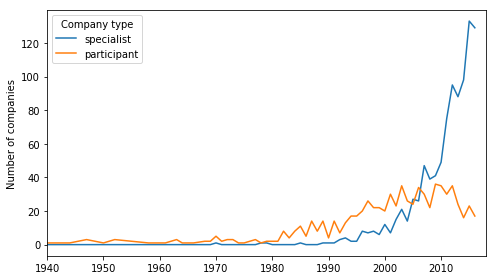

In [1188]:
#We use this to sort out the levels of engagement in variables
function_order = ['specialist','participant']


#Year
#Plot company ages by function
engagement_year = pd.crosstab(econ_data_enriched['inc_year'],econ_data_enriched['engagement_label'])


fig,ax = plt.subplots(figsize=(7,4))

engagement_year.loc[engagement_year.index<2017][function_order].plot(ax=ax)

ax.set_xlim([1940,2018])
#ax.set_title('Incorporation date by type of company',size=16)
ax.set_ylabel('Number of companies')
ax.legend().set_title('Company type')
ax.set_xlabel('')

save_fig('incorporation_date')

In [686]:
#Look at the cumulative share of activity
cumulative_share = engagement_year['specialist'].cumsum()/engagement_year['specialist'].sum()
cumulative_share[-10:]

inc_year
2009    0.282443
2010    0.329198
2011    0.400763
2012    0.491412
2013    0.575382
2014    0.668893
2015    0.795802
2016    0.918893
2017    0.992366
2018    1.000000
Name: specialist, dtype: float64

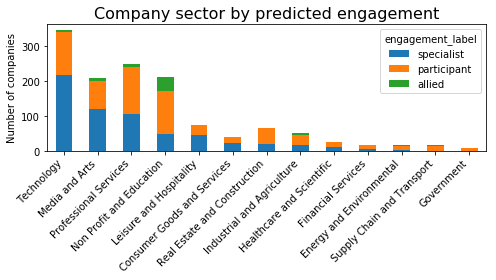

In [687]:
#Plot company functions by sector

sector_function = pd.crosstab(econ_data_enriched.Sector,econ_data_enriched.engagement_label)
sector_function.sort_values('specialist',ascending=False,inplace=True)

fig,ax = plt.subplots(figsize=(7,4))

sector_function[function_order].plot.bar(stacked=True,ax=ax)
ax.set_title('Company sector by predicted engagement',size=16)
ax.set_ylabel('Number of companies')
ax.set_xticklabels(sector_function.index,rotation=45,ha='right')
ax.set_xlabel('')

save_fig('sector_engagement')



In [688]:
100*pd.crosstab(econ_data_enriched.Sector,econ_data_enriched.engagement_label,normalize=1).sort_values(
    'participant',ascending=False)

engagement_label,allied,participant,specialist
Sector,,,
Professional Services,9.722222,21.159875,17.285945
Non Profit and Education,54.166667,19.592476,7.754443
Technology,5.555556,19.435737,35.218094
Media and Arts,11.111111,12.539185,19.386107
Real Estate and Construction,2.777778,6.896552,3.392569
Industrial and Agriculture,5.555556,4.858934,2.584814
Leisure and Hospitality,0.000000,4.388715,7.269790
Consumer Goods and Services,0.000000,2.821317,3.554120
Healthcare and Scientific,0.000000,2.194357,1.777060


In [689]:
enriched_data.groupby('engagement_label')['age'].mean()

engagement_label
allied         12.064103
participant    18.629053
specialist      6.861641
Name: age, dtype: float64

## 3. Mapping

Here we want to show:
* A map of activity across the UK (again by company types)
* A map of diffusion of activity (eg years when a TTWA reached more than 5 companies incorporated)
* A map of activity by sector (with LQs)



In [690]:
import geopandas as gp

uk_map = gp.read_file(ext_data+'/StatPlanet_UK/map/map.shp')

ttwa_shp = gp.read_file(ext_data+'/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3 2/TTWA_2011_UK_BGC_V3.shp')

In [691]:
def immersive_map(df,ax,my_cmap='YlOrRd'):
    '''
    Creates a choropleth for a sector and variable. Considers a specialisation variable to 
    colour and an activity variable to threshold
    
    '''
    
    #Map
    map_data = df.loc[df.sector==sector,:]
    
    #Select the data to map if there is specialisation and the variable is above a certain threshold
    map_data['processed'] = [x if x>1 and y> map_data[act_var].quantile(threshold) else np.nan 
                             for x,y in zip(map_data[esp_var],map_data[act_var])]
    
    #Then quantise
    map_data['processed_quantised'] = pd.qcut(map_data['processed'],
                                             q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
   
    #Plot map
    map_data.plot(ax=ax,color='lightgrey',
                  #edgecolor='white',linewidth=0.5
                 )
    
    
    m=map_data.dropna(axis=0,subset=['processed']).plot(ax=ax,
                  column='processed_quantised',
                  #color=['coral' if x >1 else 'steelblue' for x in map_data[variable_to_map]],
                  #legend=True,
                                                      cmap=my_cmap
                 )
    
    #Set axis off
    ax.set_xlim(0,940000)
    ax.axis('off')
    
    ax.set_title(sector,y=1.01,size=12)
    return(m)

#Functions
def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['year'] = year
    
    return(lqs)

def filter_lq(df,variable,thres=90):
    '''
    This is to filter LQs based on the absolute value
    
    '''
    
    threshold = np.percentile(df[variable],thres)
    #print(threshold)
    
    filtered_var = [x if y>threshold else np.nan for x,y in zip(df[variable+'_lq'],df[variable])]
    
    return(filtered_var)

In [743]:
# What data are we going to work with?

#Number of immersive companies per TTWA
ttwa_immersive_funct = pd.crosstab(econ_data_enriched.ttwa_name,econ_data_enriched.engagement_label)
ttwa_immersive_funct = ttwa_immersive_funct[['pseudo' not in x for x in ttwa_immersive_funct.index]]

ttwa_immersive_total = ttwa_immersive_funct.sum(axis=1)
ttwa_immersive_total.name='immersive_total'

ttwa_immersive_total.sort_values(ascending=False)[:20]/ttwa_immersive_total.sum()

np.sum(ttwa_immersive_total.sort_values(ascending=False)>10)

ttwa_immersive_10 = ttwa_immersive_total.sort_values(ascending=False).index[
    ttwa_immersive_total.sort_values(ascending=False)>10]

Index(['London', 'Manchester', 'Slough and Heathrow', 'Brighton', 'Bristol',
       'Birmingham', 'Newcastle', 'Cambridge', 'Liverpool',
       'Guildford and Aldershot', 'Edinburgh', 'Oxford', 'Luton', 'Nottingham',
       'Belfast', 'Reading', 'Cardiff', 'Leeds', 'Southampton', 'Glasgow',
       'Sheffield', 'Portsmouth', 'Leicester', 'Aberdeen'],
      dtype='object', name='ttwa_name')

In [698]:
100*econ_data_enriched.reg_name.value_counts(ascending=False)/econ_data_enriched.reg_name.value_counts().sum()

London                      38.876890
South East                  13.966883
North West                   9.071274
East of England              6.839453
South West                   6.623470
West Midlands                5.327574
Yorkshire and The Humber     4.679626
Scotland                     4.103672
East Midlands                4.031677
North East                   2.663787
Wales                        2.087833
Northern Ireland             1.223902
Channel Islands              0.359971
Isle of Man                  0.143988
Name: reg_name, dtype: float64

In [699]:
38+13

51

In [480]:
#IDBR totals
idbr_norm = idbr.loc[idbr.year=='2015_2016',
                     ['ttwa_name','not_creative','All creative industries']].set_index('ttwa_name').sum(axis=1)

#Specialisation index
ttwa_specialisation_function = create_lq_df(
    pd.concat([ttwa_immersive_funct,idbr_norm],axis=1)).fillna(0)

ttwa_specialisation_function.columns = ['allied_lq','participant_lq','specialist_lq','other_lq']

#All immersive specialisation index
ttwa_specialisation_immersive = create_lq_df(
    pd.concat([ttwa_immersive_funct.sum(axis=1),idbr_norm],axis=1)).fillna(0)

ttwa_specialisation_immersive.columns = ['immersive_total_lq','other_lq_2']

#ttwa_specialisation_immersive.sort_values('immersive_lq',ascending=False)

#TTWA polygons
ttwa_poly = pd.concat([ttwa_shp.set_index('TTWA11NM'),ttwa_immersive_funct,ttwa_immersive_total,
                     ttwa_specialisation_function,ttwa_specialisation_immersive],axis=1).fillna(0)

ttwa_poly = ttwa_poly.loc[:,['other' not in x for x in ttwa_poly.columns]]

#TTWA poly with thresholds
ttwa_poly_filtered = ttwa_poly.copy()

for x in ['immersive_total','specialist','participant','allied']:
    #print(x)
    ttwa_poly_filtered[x+'_lq']=filter_lq(ttwa_poly_filtered,x)

In [728]:
#Look at specialisation in the biggest places
ttwa_specialisation_immersive.loc[ttwa_immersive_10].sort_values('immersive_total_lq',ascending=False)

,immersive_total_lq,other_lq_2
ttwa_name,,
Brighton,4.058586,0.998692
Newcastle,2.160195,0.999504
Liverpool,2.090431,0.999534
Bristol,1.803419,0.999656
London,1.798119,0.999659
Cambridge,1.560100,0.999761
Edinburgh,1.552565,0.999764
Oxford,1.476115,0.999796
Nottingham,1.377246,0.999839


[Text(0,0,'Technology'),
 Text(0,0,'Professional Services'),
 Text(0,0,'Media and Arts'),
 Text(0,0,'Non Profit and Education'),
 Text(0,0,'Leisure and Hospitality'),
 Text(0,0,'Real Estate and Construction'),
 Text(0,0,'Industrial and Agriculture'),
 Text(0,0,'Consumer Goods and Services'),
 Text(0,0,'Healthcare and Scientific'),
 Text(0,0,'Financial Services'),
 Text(0,0,'Energy and Environmental'),
 Text(0,0,'Supply Chain and Transport'),
 Text(0,0,'Government')]

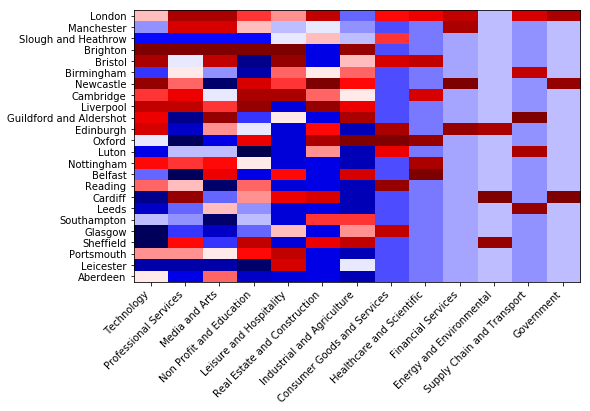

In [746]:
#Consider a segment of the data with only specialist and participant companies and check their sector spec

econ_data_core = econ_data_enriched.loc[[any(w ==x for w in ['specialist','participant']) for x
                                        in econ_data_enriched.engagement_label],:]

sectors_ranked = econ_data_core.Sector.value_counts(ascending=False).index

ttwa_sector = create_lq_df(
    pd.concat([pd.crosstab(econ_data_core.ttwa_name,
                           econ_data_core.Sector),idbr_norm],axis=1)).loc[ttwa_immersive_10].drop(0,axis=1)

fig,ax = plt.subplots(figsize=(8,5))


ax.imshow(ttwa_sector.loc[ttwa_immersive_10,sectors_ranked].rank(axis=0),cmap='seismic',aspect='auto')

ax.set_yticks(np.arange(len(ttwa_immersive_10)))
ax.set_yticklabels(ttwa_immersive_10)



ax.set_xticks(np.arange(len(sectors_ranked)))
ax.set_xticklabels(sectors_ranked,rotation=45,ha='right')



In [1367]:
#I want a map of deciles

def make_map(poly_df,variable,title,ax,decile=False,rank=False,cmap='viridis'):
    '''
    This makes a map of activity based on deciles
    
    '''
    
    poly_df = poly_df.copy()
    
    if decile==True:
        poly_df[variable] =  pd.qcut(poly_df[variable],
                                     q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    if rank==True:
        poly_df[variable]=poly_df[variable].rank()
    
    

    m=poly_df.plot(variable,ax=ax,cmap=cmap,edgecolor='black',linewidth=0.1
                   #legend=True
                  )
    
    #Set axis off
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title,size=16)
    #ax.legend(title='Decile of activity')
    
    return(ax)



def make_year_map(poly_df,variable,title,ax,decile=False,rank=False,cmap='viridis'):
    '''
    This makes a map of activity based on deciles
    
    '''
    
    poly_df = poly_df.copy()
    
    if decile==True:
        poly_df[variable] =  pd.qcut(poly_df[variable],
                                     q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    if rank==True:
        poly_df[variable]=poly_df[variable].rank()
    
    

    m=poly_df.plot(variable,ax=ax,cmap=cmap,edgecolor='slategrey',linewidth=0.4,vmin=0,vmax=4
                   #legend=True
                  )
    
    #Set axis off
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title,size=16)
    #ax.legend(title='Decile of activity')
    
    return(ax)

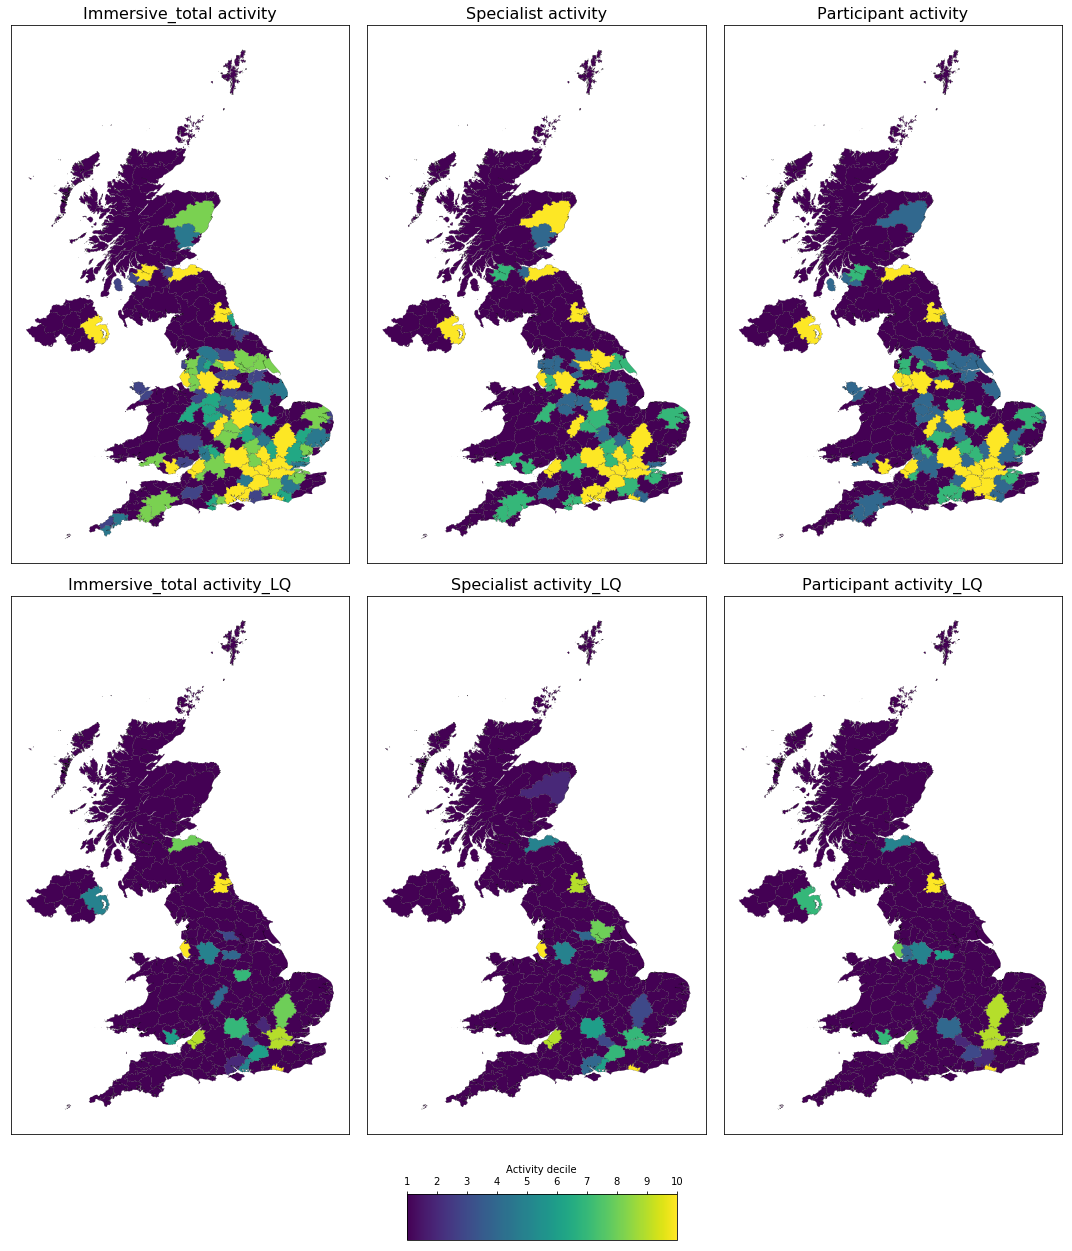

In [1390]:
import matplotlib.patches as mpatches
import matplotlib as mpl
import squarify
from matplotlib import patches

fig,ax = plt.subplots(figsize=(15,16),nrows=2,ncols=3)

for num,x in enumerate(['immersive_total','specialist','participant']):
    make_map(ttwa_poly,x,'{name} activity'.format(name=x.capitalize()),ax=ax[0][num],decile=True,cmap='viridis')
    #ax[num].get_legend().set_visible(False)
    make_map(ttwa_poly_filtered,x+'_lq','{name} activity_LQ'.format(name=x.capitalize()),ax=ax[1][num],decile=True,
            cmap='viridis')
    

plt.tight_layout()

#Add colorbar

cbar_ax = fig.add_axes([0.38, -0.08, 0.25, 0.04])

norm = mpl.colors.Normalize(vmin=1,vmax=10)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap='viridis',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Activity decile')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')

plt.savefig(fig_path+'/{date}_specialisation_map.png'.format(date=today_str),bbox_inches='tight')


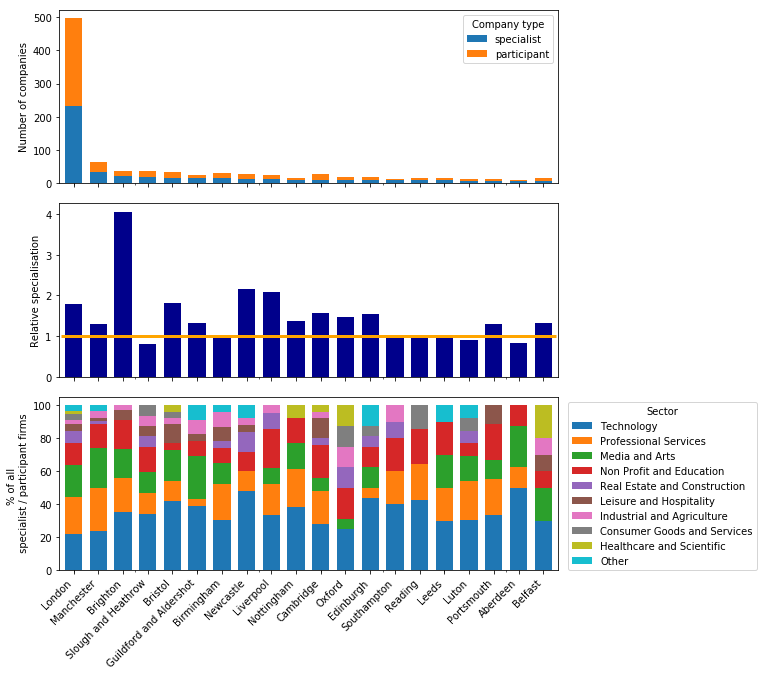

In [1359]:
#Now the other activity plots
#One with totals, specialisations and sectors

#Totals of activity
ttwa_function_distr = pd.crosstab(
    econ_data_enriched.ttwa_name,econ_data_enriched.engagement_label).sort_values(
    'specialist',ascending=False)[['specialist','participant']]

#And we select the top 30 places
top_30_places = ttwa_function_distr.index[:20]

top_30_specialisation=ttwa_specialisation_immersive['immersive_total_lq'].loc[top_30_places]

#Sectoral distribution of activity by TTWA

ttwa_sector = pd.crosstab(econ_data_enriched.loc[[x in [
    'participant','specialist'] for x in econ_data_enriched.engagement_label],'ttwa_name'],
                          econ_data_enriched.loc[[x in [
    'participant','specialist'] for x in econ_data_enriched.engagement_label],'Sector'])

#Top 9 sectors
top_sectors = ttwa_sector.sum().sort_values(ascending=False).index[:9]

ttwa_sector['Other'] = ttwa_sector.loc[:,[x not in top_sectors for x in ttwa_sector.columns]].sum(axis=1)

top_30_sectoral = 100*ttwa_sector.loc[top_30_places,list(top_sectors)+['Other']].apply(lambda x: x/x.sum(),axis=1)

#Plot everything
#Draw figure
fig,ax = plt.subplots(figsize=(8,9.5),nrows=3,sharex=True)

#Plot the function by city
ttwa_function_distr.loc[top_30_places].plot.bar(stacked=True,ax=ax[0],width=0.7)
ax[0].set_ylabel('Number of companies')

ax[0].legend().set_title('Company type')

#Plot the specialisation
top_30_specialisation.plot.bar(stacked=True,ax=ax[1],color='darkblue',width=0.7)
ax[1].set_ylabel('Relative specialisation')

#Hline for Lq=1
ax[1].hlines(y=1,xmin=-0.5,xmax=19.5,color='orange',linewidth=3)

#Plot sectoral specialisations
top_30_sectoral.plot.bar(stacked=True,ax=ax[2],width=0.7)
ax[2].set_xticklabels(top_30_sectoral.index,rotation=45,ha='right')
ax[2].set_ylabel('% of all \n specialist / participant firms')

ax[2].legend(bbox_to_anchor=(1.01,1),title='Sector')
ax[2].set_xlabel('')

#ax[0].set_title('Immersive activity and composition in top 20 TTWAs',size=16)

plt.tight_layout()

save_fig('activity_composition')


In [1360]:
#shares_activity = 100*ttwa_immersive_totals.sort_values(ascending=False)/ttwa_immersive_totals.sum()
#shares_activity[:5]

#ttwa_function_distr.sum(axis=1).sort_values(ascending=False)

#top_30_specialisation.sort_values(ascending=False)

In [1403]:
#We want to compare levels of specialisation in participant and specialist sectors but only focusing 
#on places with more than 10 imm comps

#Get places with more than 10 immersive companies

above_10 = ttwa_function_distr[ttwa_function_distr.sum(axis=1)>10].index


ttwa_specialisation_function.loc[above_10,:].corr(method='spearman')

#plt.scatter(ttwa_specialisation_function.loc[above_10,'specialist_lq'],
#            ttwa_specialisation_function.loc[above_10,'participant_lq'])

,allied_lq,participant_lq,specialist_lq,other_lq
allied_lq,1.000000,0.199322,-0.101648,-0.219765
participant_lq,0.199322,1.000000,0.504235,-0.887069
specialist_lq,-0.101648,0.504235,1.000000,-0.783173
other_lq,-0.219765,-0.887069,-0.783173,1.000000


## 4. Drivers and barriers

Here we go back to an analysis of the survey data. We need to create a couple of functions to make this
analysis efficient

### Performance

Includes:

* Growth
* Confidence

Subset by place, company type.


In [951]:
print(mtm.q20_growth.value_counts(normalize=True))

print('\n')
print(mtm.q22_business_confidence.value_counts(normalize=True))


Higher than twelve months ago    0.563177
The same as twelve months ago    0.332130
Lower than twelve months ago     0.104693
Name: q20_growth, dtype: float64


Very confident        0.488636
Quite confident       0.390152
Neutral               0.106061
Not very confident    0.015152
Name: q22_business_confidence, dtype: float64


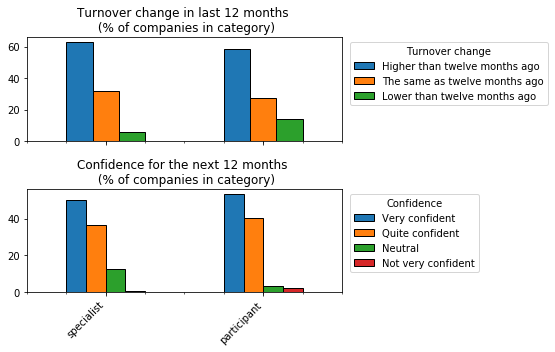

In [1201]:
#Performance 

fig, ax = plt.subplots(figsize=(5,5),sharex=True,nrows=2)


#Plot 1
growth_ct = 100*pd.crosstab(mtm.q20_growth,mtm.function,normalize=1).T

growth_ct.loc[function_order].iloc[
    :,[0,2,1]].plot.bar(ax=ax[0],edgecolor=['black']*3)

#Move legend outside
ax[0].legend(bbox_to_anchor=(1.01,1),title='Turnover change')

#Plot 2 (confidence)
conf_ct = 100*pd.crosstab(mtm.q22_business_confidence,mtm.function,normalize=1).T

conf_ct.loc[
    function_order].iloc[:,[3,2,0,1]].plot.bar(ax=ax[1],edgecolor=['black']*3)

ax[1].legend(bbox_to_anchor=(1.01,1),title='Confidence')

#Titles and labels
ax[0].set_title('Turnover change in last 12 months \n (% of companies in category)',size=12)
ax[1].set_title('Confidence for the next 12 months \n (% of companies in category)',size=12)

ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45,ha='right')

ax[1].set_xlabel('')

save_fig('growth_expectations_engagement')

In [953]:
#Growth stats
pd.crosstab(mtm.q20_growth,mtm.function,normalize=1)

function,allied,participant,specialist
q20_growth,,,
Higher than twelve months ago,0.315789,0.586207,0.627273
Lower than twelve months ago,0.131579,0.137931,0.054545
The same as twelve months ago,0.552632,0.275862,0.318182


In [954]:
#Compared with other sectors?

#Load some data from Creative Nation
gdyn = pd.read_excel(ext_data+'/gdyn.xlsx',sheet_name='UK_subsector')

#Focus on the most recent period
gdyn_recent = gdyn.loc[gdyn.cohort=='2013-2016',:]

gdyn_recent['grew'] = [any(w in x for w in ['birth','inc','hgr','logr']) for x in gdyn_recent.bandemployment]


In [955]:
gdyn_recent.groupby(['industry_aggr','grew'])['entref'].sum().groupby(level=0).apply(lambda x:x/x.sum())

industry_aggr  grew 
Creative       False    0.599764
               True     0.400236
Non-creative   False    0.609647
               True     0.390353
Name: entref, dtype: float64

In [956]:
63/40
63/39

1.6153846153846154

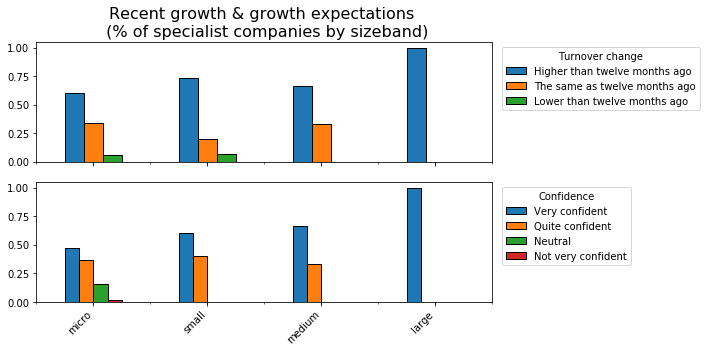

In [957]:
#Performance by size

size_order = ['micro','small','medium','large']

mtm_spec = mtm.loc[[x in ['specialist'] for x in mtm.function],:]
#Performance 

fig, ax = plt.subplots(figsize=(7,5),sharex=True,nrows=2)


#Plot 1
growth_ct = pd.crosstab(mtm_spec.q20_growth,mtm_spec.comp_size,normalize=1).T.loc[size_order].iloc[
    :,[0,2,1]].plot.bar(ax=ax[0],edgecolor=['black']*4)

#Move legend outside
ax[0].legend(bbox_to_anchor=(1.01,1),title='Turnover change')

#Plot 2 (confidence)
conf_ct = pd.crosstab(mtm_spec.q22_business_confidence,mtm_spec.comp_size,normalize=1).T.loc[size_order].iloc[
    :,[3,2,0,1]].plot.bar(ax=ax[1],edgecolor=['black']*4)


ax[1].legend(bbox_to_anchor=(1.01,1),title='Confidence')

#Titles and labels
ax[0].set_title('Recent growth & growth expectations \n (% of specialist companies by sizeband)',size=16)

ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45,ha='right')

ax[1].set_xlabel('')

save_fig('growth_expectations_size')

In [958]:
pd.crosstab(mtm.q22_business_confidence,mtm.function,normalize=1)

function,allied,participant,specialist
q22_business_confidence,,,
Neutral,0.263158,0.034483,0.127273
Not very confident,0.000000,0.025862,0.009091
Quite confident,0.421053,0.405172,0.363636
Very confident,0.315789,0.534483,0.500000


### Trade

Includes:

* Trade with other sectors
* International trade


In [959]:
def process_question(survey_data,var_name,var_type='binary',var_int = 'Very important'):
    '''
    This function turns a variable into counts. 
    
    '''
    if var_type=='binary':
    
        data = survey_data.loc[:,[var_name in x for x in survey_data.columns]]
        data_bin = data.applymap(lambda x: 1 if x !='No' else 0)
        
    elif var_type=='likert':
        data = survey_data.loc[:,[var_name in x for x in survey_data.columns]]
        data_bin = data.applymap(lambda x: 1 if x==var_int else 0)
        
    
    return([data,data_bin])
    

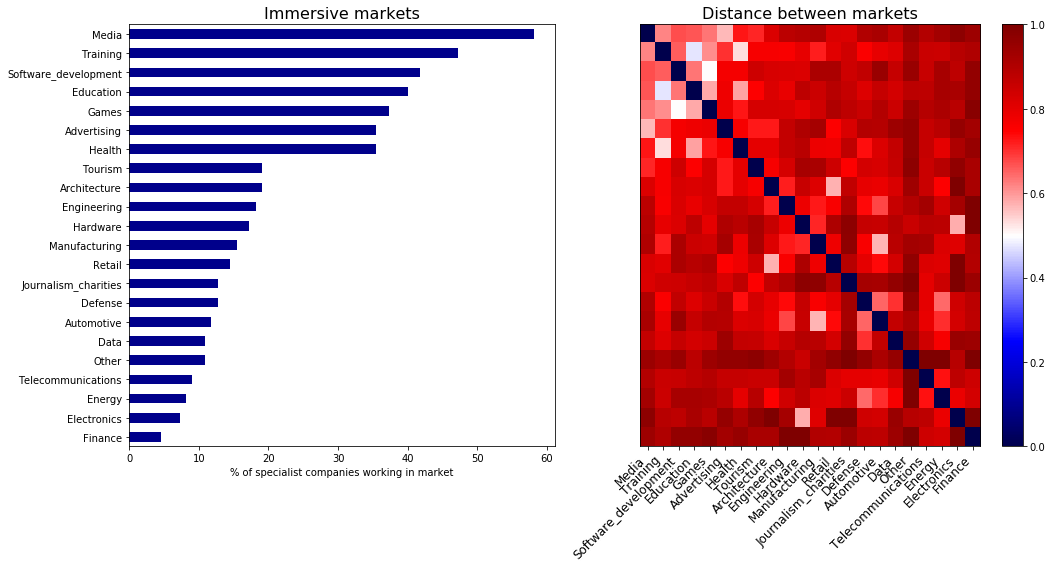

In [960]:
#Trade with other sectors

#Process question into binary and look at the distribution
trade = process_question(mtm_spec,'q18')

#This is to normalise
tot = len(trade[1])

#Create %
spec_trade = 100*trade[1].sum().sort_values(ascending=True)/tot

#Plot
fig,ax = plt.subplots(figsize=(15,8),ncols=2)

#Create plot
spec_trade.plot.barh(color='darkblue',ax=ax[0])

#Clean labels
ax[0].set_yticklabels([x[12:].capitalize() for x in spec_trade.index])

ax[0].set_title('Immersive markets',size=16)
ax[0].set_xlabel('% of specialist companies working in market')

draw_heatmap(trade[1][spec_trade.index[::-1]].T,'jaccard',ax=ax[1],title='Market correlation')
ax[1].set_title('Distance between markets',size=16)
ax[1].get_yaxis().set_visible(False)
ax[1].set_xticklabels([x[12:].capitalize() for x in spec_trade.index[::-1]],rotation=45,ha='right',size=12)

plt.subplots_adjust(wspace=0.1)

save_fig('markets')

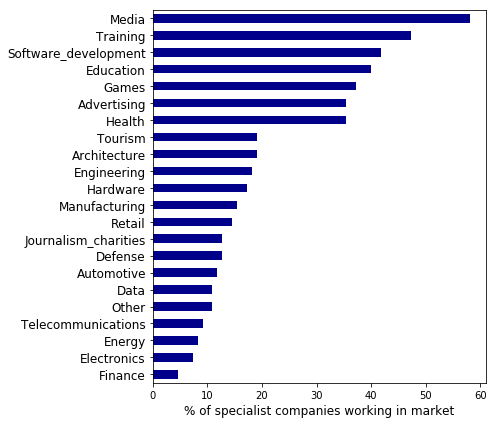

In [1216]:
fig,ax = plt.subplots(figsize=(7,6))

#Create plot
spec_trade.plot.barh(color='darkblue',ax=ax)

#Clean labels
ax.set_yticklabels([x[12:].capitalize() for x in spec_trade.index],size=12)

#ax.set_title('Immersive markets',size=16)
ax.set_xlabel('% of specialist companies working in market',size=12)

save_fig('immersive_markets')


In [961]:
np.sum(trade[1].loc[
    :,[any(w in x for w in ['games','media','software','advertising']) for x in trade[1].columns]].sum(axis=1)>0)

92/len(trade[1])

0.8363636363636363

In [962]:
#Trade with non-media companies§
trade_non_media = trade[1].loc[:,[all(
    name not in x for name in ['games','media','software','advertising']) for x in trade[1].columns]]


np.sum(trade_non_media.sum(axis=1)>1)/len(trade_non_media)

trade_non_media.sum().sort_values()

q18_clients_finance                  5
q18_clients_electronics              8
q18_clients_energy                   9
q18_clients_telecommunications      10
q18_clients_other                   12
q18_clients_data                    12
q18_clients_automotive              13
q18_clients_defense                 14
q18_clients_journalism_charities    14
q18_clients_retail                  16
q18_clients_manufacturing           17
q18_clients_hardware                19
q18_clients_engineering             20
q18_clients_tourism                 21
q18_clients_architecture            21
q18_clients_health                  39
q18_clients_education               44
q18_clients_training                52
dtype: int64

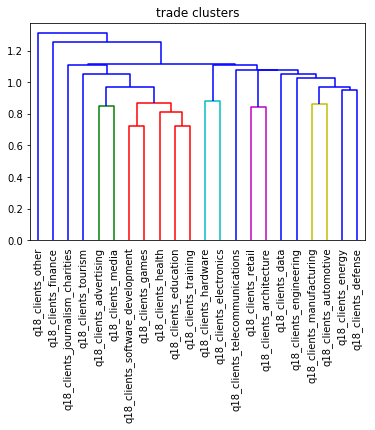

In [1223]:
fig,ax = plt.subplots()

draw_dendrogram(trade[1].T,'jaccard',ax,title='trade clusters')

labs = ax.xaxis.get_ticklabels()

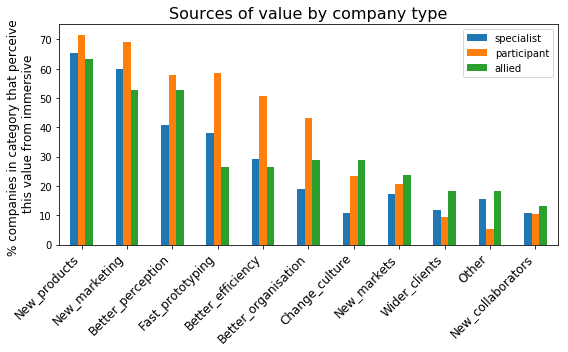

In [964]:
#Sources of value
value_types = pd.concat([100*process_question(
    mtm.loc[mtm.function==x,:],'q7_',var_type='binary')[1].mean() for x in ['specialist',
                                                                                   'participant','allied']],axis=1)
#Add columns
value_types.columns = ['specialist','participant','allied']

#Order for plotting
value_types_ordered = value_types.sum(axis=1).sort_values(ascending=False).index

#Plot
fig, ax = plt.subplots(figsize=(8,5))

value_types.loc[value_types_ordered,:].plot.bar(ax=ax)

ax.set_xticklabels([x[9:].capitalize() for x in value_types_ordered],rotation=45,ha='right',size=12)

ax.set_title('Sources of value by company type',size=16)
ax.set_ylabel('% companies in category that perceive \n this value from immersive',size=12)

save_fig('immersive_value')



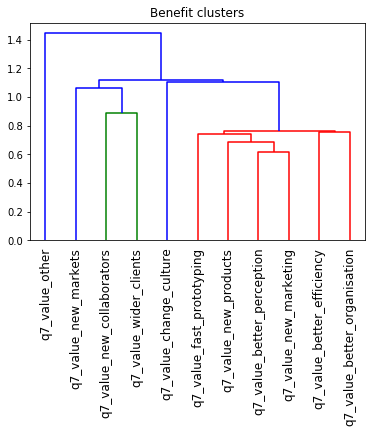

In [965]:
#Sources of value for companies: clusters

fig,ax = plt.subplots()

draw_dendrogram(process_question(mtm,'q7_',var_type='binary')[1].T,'jaccard',ax,'Benefit clusters')

#Store labels here, to create the clusters
labels_ranked = ax.xaxis.get_ticklabels()


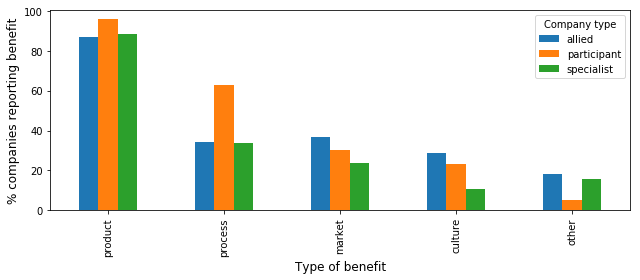

In [1270]:
#We want to group the responses into a smaller set of clusters
cluster_names = ['other','market','culture','product','process']

#Labels
label_clusters = {x.get_text():cluster_names[y] for x,y in zip(labels_ranked,[0,1,1,1,2,3,3,3,3,4,4])}

#Regroup values
val_qs = pd.melt(pd.concat([process_question(mtm,'q7_',var_type='binary')[1],
                            mtm.function],axis=1).reset_index(drop=False),id_vars=['index','function'])
                 
val_qs['cluster'] = [label_clusters[x] for x in val_qs['variable']]

val_qs_clustered = pd.pivot_table(
    val_qs.reset_index(drop=False),
    index=['index','function'],
    columns='cluster',values='value',aggfunc='sum').applymap(lambda x:1 if x>0 else 0).reset_index(
    'function',drop=False)

sorted_value_types = val_qs_clustered.iloc[:,1:].sum().sort_values().index


fig,ax = plt.subplots(figsize=(9,4))

(val_qs_clustered.groupby('function').mean()*100).T.loc[sorted_value_types[::-1]].plot.bar(ax=ax)

ax.set_ylabel('% companies reporting benefit',size=12)
ax.set_xlabel('Type of benefit',size=12)
ax.legend().set_title('Company type')

save_fig('benefit')

In [1256]:
val_qs_clustered.groupby('function').mean().T

function,allied,participant,specialist
cluster,,,
culture,0.289474,0.232759,0.109091
market,0.368421,0.301724,0.236364
other,0.184211,0.051724,0.154545
process,0.342105,0.629310,0.336364
product,0.868421,0.956897,0.881818


In [967]:
np.sum(val_qs_clustered.sum(axis=1)>1)/len(val_qs_clustered)

0.6060606060606061

In [968]:
#mtm_allied = mtm.loc[mtm.function=='allied',:]
spend_grow = [any('Expect to grow' in x for x in [a,b,c] if type(x)==str) for a,b,c in zip(mtm.q26_future_spend_other_ie,
                                                                          mtm.q26_future_spend_ar,
                                                                          mtm.q26_future_spend_vr)]

#### International trade

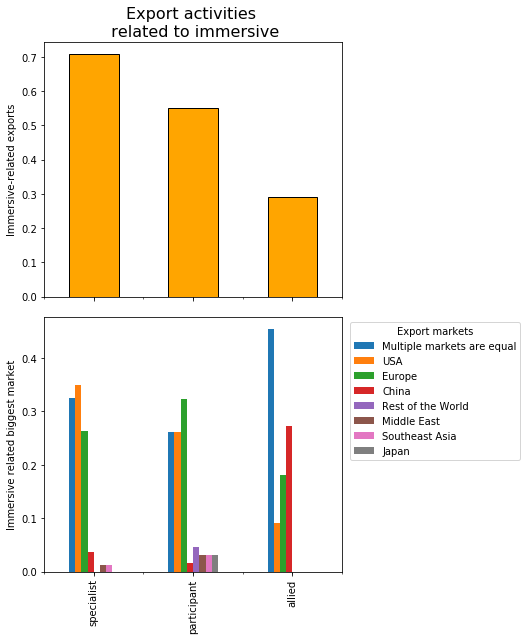

In [969]:
#Exports

fig,ax = plt.subplots(figsize=(5,9),nrows=2,sharex=True)

pd.crosstab(mtm.function,mtm.q8_immersive_export,normalize=0).loc[function_order,'Yes'].plot.bar(
    color='orange',edgecolor=['black']*3,ax=ax[0])

ax[0].set_title('Export activities \n related to immersive',size=16)
ax[0].set_ylabel('Immersive-related exports')


biggest_markets= mtm.q9_export_market.value_counts().sort_values(ascending=False).index

pd.crosstab(mtm.function,mtm.q9_export_market,normalize=0).loc[function_order,
                                                               biggest_markets].plot.bar(stacked=False,ax=ax[1])

ax[1].set_ylabel('Immersive related biggest market')

ax[1].legend(bbox_to_anchor=(1.01,1),title='Export markets')

ax[1].set_xlabel('')

save_fig('immersive_exports')



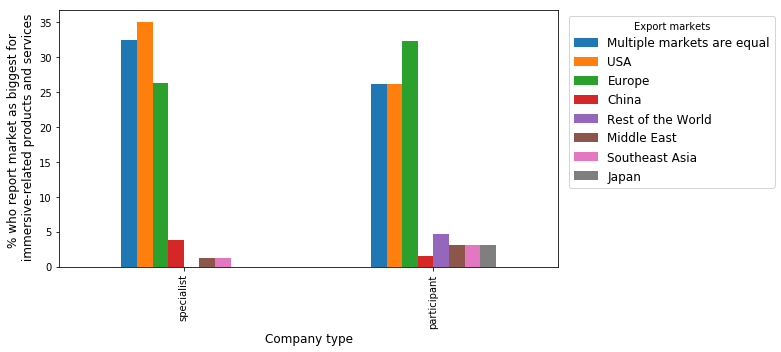

In [1282]:
fig,ax = plt.subplots(figsize=(8,5))

(100*pd.crosstab(mtm.function,mtm.q9_export_market,normalize=0)).loc[['specialist','participant'],
                                                               biggest_markets].plot.bar(stacked=False,ax=ax)

ax.set_ylabel('% who report market as biggest for \n immersive-related products and services',size=12)

ax.legend(bbox_to_anchor=(1.01,1),title='Export markets',fontsize=12)

ax.set_xlabel('Company type',size=12)

save_fig('immersive_exports')



In [970]:
pd.crosstab(mtm.function,mtm.q9_export_market,normalize=0)

q9_export_market,China,Europe,Japan,Middle East,Multiple markets are equal,Rest of the World,Southeast Asia,USA
function,,,,,,,,
allied,0.272727,0.181818,0.000000,0.000000,0.454545,0.000000,0.000000,0.090909
participant,0.015385,0.323077,0.030769,0.030769,0.261538,0.046154,0.030769,0.261538
specialist,0.037500,0.262500,0.000000,0.012500,0.325000,0.000000,0.012500,0.350000


### Place

Includes

* Local advantages
* Local barriers

In [971]:
mtm_spec_part = mtm.loc[[x in ['specialist','participant'] for x in mtm.function],:]

top_respondents = mtm_spec_part['ttwa_name'].value_counts()[:12].index

In [972]:
#What is the biggest local advantage?
factors_ordered = process_question(mtm_spec_part,'q10','likert')[1].sum().sort_values(ascending=False).index

In [973]:
#What are the top regions
regions = mtm_spec_part.reg_nat.value_counts(ascending=False).index

In [1409]:
#Process advantages
regional_advantages = 100*pd.concat([process_question(
    mtm_spec_part.loc[mtm_spec_part.reg_nat==x,:],
    'q10','likert')[1].mean() for x in regions],axis=1).loc[factors_ordered]

regional_advantages.columns = regions

#local_advantages.columns=top_respondents

#Process barriers

barriers = process_question(mtm_spec_part,'q14')[1].sum().sort_values(ascending=False)

local_barrier_vars = ['q14_barriers_skills_shortages','q14_barriers_skills_shortages_education',
                 'q14_barriers_access_university_knowledge','q14_barriers_technical_infrastructure',
                 'q14_barriers_transport','q14_barriers_lack_advice','q14_barriers_market_knowledge',
                 'q14_barriers_office_space']

reg_barriers = 100*pd.concat([process_question(
    mtm_spec_part.loc[mtm_spec_part.reg_nat==x,:],
    'q14','binary')[1].mean() for x in regions],axis=1).loc[local_barrier_vars]

reg_barriers.columns=regions


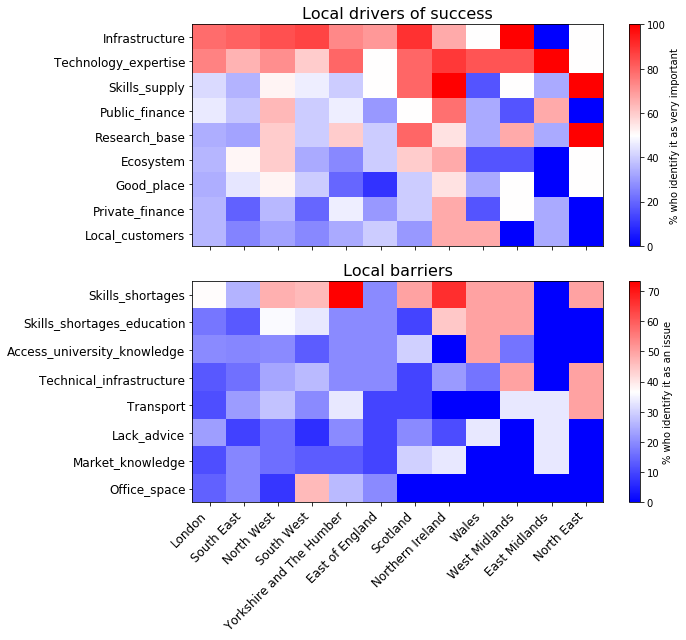

In [1418]:
fig,ax = plt.subplots(figsize=(10,9),nrows=2,sharex=True)

#First plot
mat_1 = ax[0].imshow(regional_advantages,aspect='auto',cmap='bwr')

#Y axis
ax[0].set_yticks(np.arange(len(regional_advantages)))
ax[0].set_yticklabels([x[18:].capitalize() for x in regional_advantages.index],size=12)

#X axis
ax[0].set_xticks(np.arange(len(regional_advantages.columns)))
ax[0].set_xticklabels([x for x in regional_advantages.columns],rotation=45,ha='right',size=12)

fig.colorbar(mat_1,ax=ax[0],label='% who identify it as very important')

#Second plot
mat_2 = ax[1].imshow(reg_barriers,aspect='auto',cmap='bwr')

#Y axis
ax[1].set_yticks(np.arange(len(reg_barriers)))
ax[1].set_yticklabels([x[13:].capitalize() for x in reg_barriers.index],size=12)

#X axis
ax[1].set_xticks(np.arange(len(reg_barriers.columns)))
ax[1].set_xticklabels([x for x in reg_barriers.columns],rotation=45,ha='right',size=12)

#Titles
ax[0].set_title('Local drivers of success',size=16)
ax[1].set_title('Local barriers',size=16)

fig.colorbar(mat_2,ax=ax[1],label='% who identify it as an issue')

save_fig('local_drivers_barriers')

In [976]:
all_advantages = process_question(mtm_spec_part,'q10','likert')[1].mean().sort_values(ascending=False)
all_advantages

all_barriers = process_question(mtm_spec_part,'q14','binary')[1].mean().loc[local_barrier_vars]
all_barriers

q14_barriers_skills_shortages               0.411504
q14_barriers_skills_shortages_education     0.230088
q14_barriers_access_university_knowledge    0.199115
q14_barriers_technical_infrastructure       0.194690
q14_barriers_transport                      0.168142
q14_barriers_lack_advice                    0.163717
q14_barriers_market_knowledge               0.163717
q14_barriers_office_space                   0.154867
dtype: float64

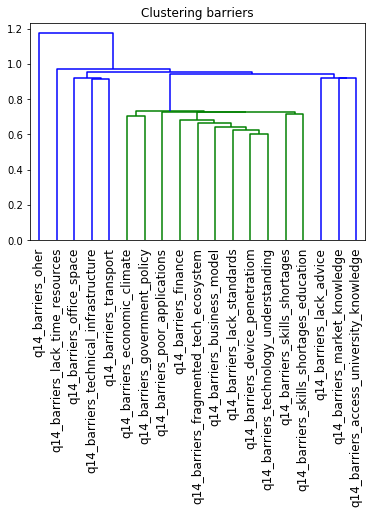

In [979]:
#Shall we cluster the barriers?

#We processs the df to put in the dendogram function
fig,ax = plt.subplots()

draw_dendrogram(process_question(mtm,'q14','binary')[1].T,'cosine',ax,'Clustering barriers')

barrier_labels = ax.xaxis.get_ticklabels()

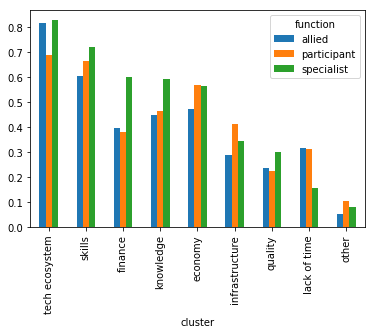

In [986]:
#I should turn this into a function
#We want to group the responses into a smaller set of clusters
barrier_cluster_names = ['other','lack of time','infrastructure','economy',
                         'quality','finance','tech ecosystem','skills','knowledge']

#Labels
label_barrier_clusters = {x.get_text():barrier_cluster_names[y] for x,y in zip(
    barrier_labels,[0,
                    1,
                    2,2,2,
                    3,3,
                    4,
                    5,
                    6,6,6,6,
                    7,7,
                    8,8,8,8])}

#Regroup values
barr_qs = pd.melt(pd.concat([process_question(mtm,'q14_',var_type='binary')[1],
                            mtm.function],axis=1).reset_index(drop=False),id_vars=['index','function'])
                 
barr_qs['cluster'] = [label_barrier_clusters[x] for x in barr_qs['variable']]

barr_qs_clustered = pd.pivot_table(
    barr_qs.reset_index(drop=False),
    index=['index','function'],
    columns='cluster',values='value',aggfunc='sum').applymap(lambda x:1 if x>0 else 0).reset_index(
    'function',drop=False)


barr_qs_clustered.groupby('function').mean().T.sort_values('specialist',ascending=False).plot.bar()

In [987]:
barr_qs_clustered.groupby('function').mean()

cluster,economy,finance,infrastructure,knowledge,lack of time,other,quality,skills,tech ecosystem
function,,,,,,,,,
allied,0.473684,0.394737,0.289474,0.447368,0.315789,0.052632,0.236842,0.605263,0.815789
participant,0.568966,0.379310,0.413793,0.465517,0.310345,0.103448,0.224138,0.663793,0.689655
specialist,0.563636,0.600000,0.345455,0.590909,0.154545,0.081818,0.300000,0.718182,0.827273


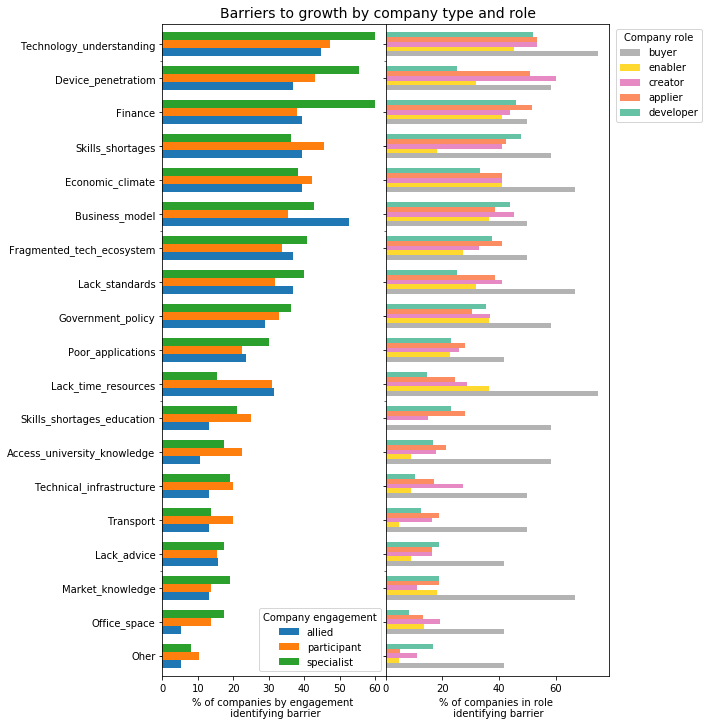

In [988]:
#Now visualise all barriers by company type and function.

#Sources of value
barrier_function = pd.concat([100*process_question(
    mtm.loc[mtm.function==x,:],
    'q14_',var_type='binary')[1].mean() for x in ['allied','participant','specialist']],axis=1).loc[barriers.index[::-1]]
#Add columns
barrier_function.columns = ['allied','participant','specialist']

#Barriers
barrier_class = pd.concat([100*process_question(
    mtm.loc[mtm.classification==x,:],'q14_',var_type='binary')[1].mean() for x in role_order[::-1]],axis=1).loc[
    barriers.index[::-1]]

barrier_class.columns = role_order[::-1]



fig,ax = plt.subplots(figsize=(8,12),ncols=2,sharey=True)

barrier_function.plot.barh(ax=ax[0],width=0.7)
barrier_class.plot.barh(ax=ax[1],cmap='Set2_r',width=0.7)

ax[0].legend(title='Company engagement')
ax[1].legend(bbox_to_anchor=(1.01,1),title='Company role')

ax[1].set_yticklabels([x[13:].capitalize() for x in barrier_function.index],size=14
                      #rotation=45,ha='right'
                     )

ax[0].set_xlabel('% of companies by engagement \n identifying barrier')
ax[1].set_xlabel('% of companies in role \n identifying barrier')

plt.subplots_adjust(wspace=0)

fig.suptitle('Barriers to growth by company type and role',size=14,y=0.9)

plt.savefig(fig_path+'/{date}_business_barriers.pdf'.format(date=today_str),bbox_inches='tight')

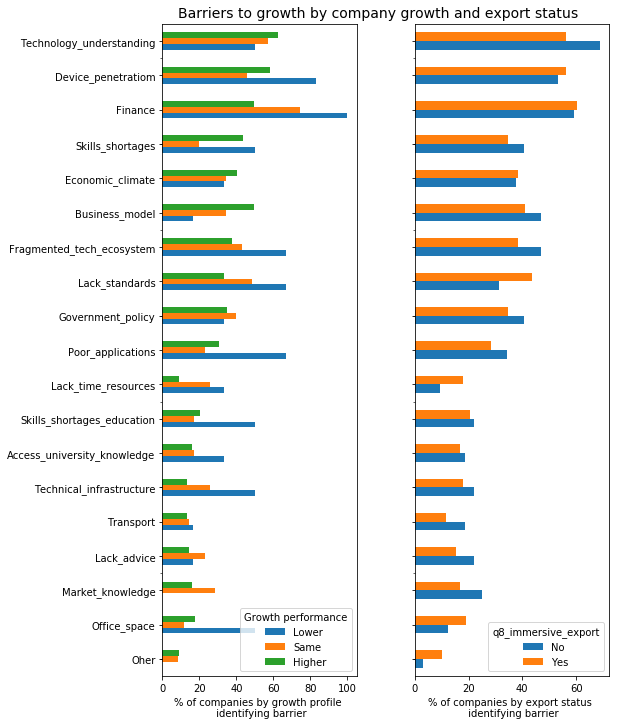

In [989]:
#Links between barriers to growth and compamy types (growers / exporters)

#NEED to turn these into functions
#Gnarly way to run a processed question vs a categorical question
barrier_growth = 100*pd.concat([pd.crosstab(
    mtm_spec.q20_growth,
    process_question(mtm_spec,'q14_',var_type='binary')[1][x],normalize=0)[1] for x in
                            [x for x in mtm_spec.columns if 'q14_' in x]],axis=1)

#Again
barrier_export = 100*pd.concat([pd.crosstab(
    mtm_spec.q8_immersive_export,
    process_question(mtm_spec,'q14_',var_type='binary')[1][x],normalize=0)[1] for x in
                            [x for x in mtm_spec.columns if 'q14_' in x]],axis=1)

barrier_growth.columns = [x for x in mtm_spec.columns if 'q14_' in x]
barrier_export.columns = [x for x in mtm_spec.columns if 'q14_' in x]



fig,ax = plt.subplots(figsize=(8,12),ncols=2,sharey=True)

barrier_growth.T.loc[barriers.index[::-1]].iloc[:,[1,2,0]].plot.barh(ax=ax[0])


barrier_export.T.loc[barriers.index[::-1]].plot.barh(ax=ax[1])

#Legends
ax[0].legend(labels = [x.split(' ')[0] if 'same' not in x else 'Same' for x in barrier_growth.index[[1,2,0]]],
             title='Growth performance')
#ax[1].legend(bbox_to_anchor=(1.01,1),title='Exporting company')



ax[1].set_yticklabels([x[13:].capitalize() for x in barrier_function.index],size=14
                      #rotation=45,ha='right'
                     )

ax[0].set_xlabel('% of companies by growth profile \n identifying barrier')
ax[1].set_xlabel('% of companies by export status \n identifying barrier')

plt.subplots_adjust(wspace=0.3)

fig.suptitle('Barriers to growth by company growth and export status',size=14,y=0.9)

plt.savefig(fig_path+'/{date}_business_barriers_growth.pdf'.format(date=today_str),bbox_inches='tight')

### Access to support

In [990]:
def plot_access_support(variable,title,var_cut):
    '''
    Plots access to support by variable
    
    '''
    #Totals (for ordering)
    totals =process_question(mtm,variable,var_type='likert',var_int='Received')[1].sum()
    totals_order = totals.sort_values(ascending=False).index
    
    
    #Sources of value
    access_function = pd.concat([100*process_question(
        mtm.loc[mtm.function==x,:],
        variable,var_type='likert',var_int='Received')[1].mean() for x in ['allied','participant','specialist']],
                                axis=1).loc[totals_order[::-1]]
    #Add columns
    access_function.columns = ['allied','participant','specialist']

    #Barriers
    access_class = pd.concat([100*process_question(
        mtm_spec.loc[mtm_spec.classification==x,:],variable,
        var_type='likert',var_int='Received')[1].mean() for x in role_order[::-1]],axis=1).loc[
        totals_order[::-1]]

    access_class.columns = role_order[::-1]


    fig,ax = plt.subplots(figsize=(8,12),ncols=2,sharey=True)

    access_function.plot.barh(ax=ax[0],width=0.7)
    access_class.plot.barh(ax=ax[1],cmap='Set2_r',width=0.7)

    ax[0].legend(title='Company engagement')
    ax[1].legend(bbox_to_anchor=(1.01,1),title='Company role')

    ax[1].set_yticklabels([x[var_cut:].capitalize() for x in totals.index],size=14
                          #rotation=45,ha='right'
                         )

    ax[0].set_xlabel('% of companies by engagement \n accessing support')
    ax[1].set_xlabel('% of specialist companies in role \n accessing support')

    plt.subplots_adjust(wspace=0)

    fig.suptitle('Access to {name} by company type and role'.format(name=title),size=14,y=0.9)

    #return(ax)
    
plt.savefig(fig_path+'/{date}_access_to_support.pdf'.format(date=today_str),bbox_inches='tight')

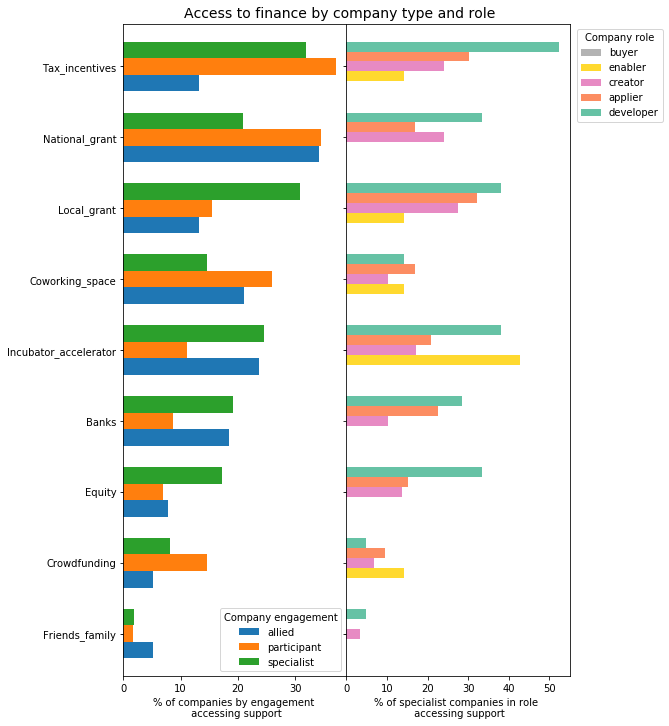

In [991]:
plot_access_support('q12_','finance',var_cut=12)
plt.savefig(fig_path+'/{date}_access_to_support.pdf'.format(date=today_str),bbox_inches='tight')

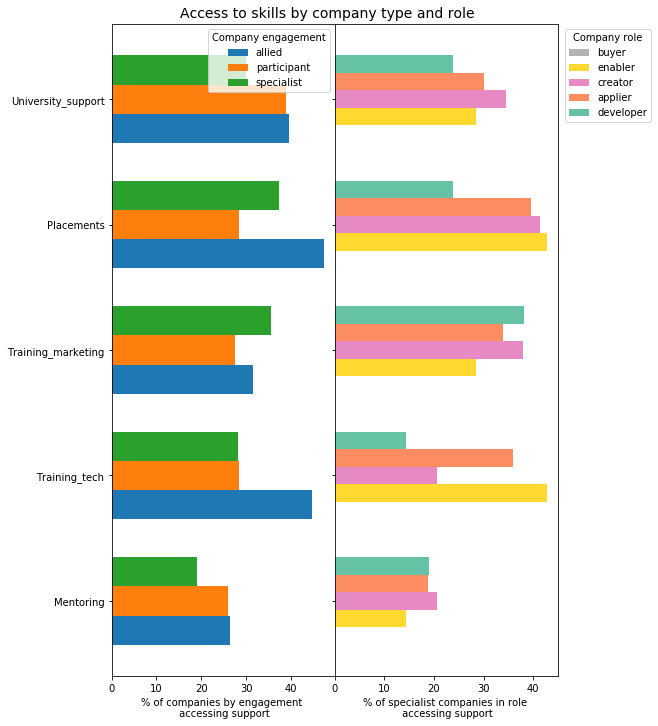

In [992]:
plot_access_support('q13_','skills',var_cut=18)
plt.savefig(fig_path+'/{date}_access_to_support_skills.pdf'.format(date=today_str),bbox_inches='tight')

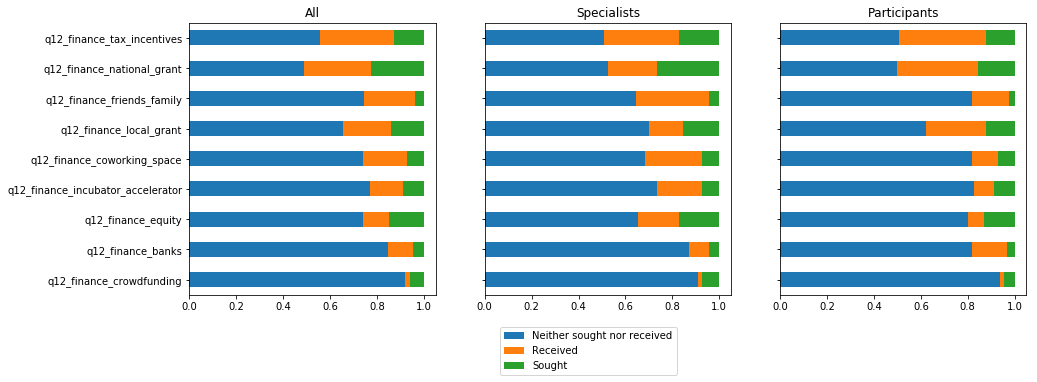

In [993]:
#Now we want to visualise the extent to which immersive companies access different types of 
#support. This will be chart that gets, for each type of company (specialis, participant etc.) their
#engagement with different types of programmes,.

finance_variables = [x for x in mtm.columns if 'q12_' in x]

def extract_policy_engagement(data,variable):
    '''
    This function extracts the distribution of engagement with a policy by question
    
    '''
    #Distribution of results
    results = data[variable].value_counts(normalize=True)
    
    #And their name
    results.name=variable
    
    #Return it
    return(results)


#Creatye a financial ranking
finance_ranked = pd.concat(
    [extract_policy_engagement(
        mtm,x) for x in finance_variables],axis=1).T.sort_values('Received',ascending=False).index[::-1]


#Plot
fig,ax = plt.subplots(figsize=(15,5),ncols=3,sharey=True)

#This creates a list with 3 crosstabs
policy_engs = [pd.concat([extract_policy_engagement(
    mtm.loc[[x in function for x in mtm.function]],x) for x in finance_variables],
                         axis=1).T.loc[finance_ranked] for function in [['participant','specialist','allied'],
                                                                       ['specialist'],['participant']]]

#And then we plot them
[x[0].plot.barh(stacked=True,ax=ax[num],title=x[1],
             legend = True if num==0 else False) for num,x in enumerate(zip(
    policy_engs,['All','Specialists','Participants']))]

#Move the legend
ax[0].legend(bbox_to_anchor=[2,-0.1])

In [994]:
for x,y in zip(policy_engs,['all','spec','part']):
    
    print(y.upper())
    
    out = x.sort_values('Received',ascending=False)
    out['success_rate'] = x['Received']/(x['Sought']+x['Received'])
    print(out)
    print('\n')
    print('\n')

ALL
                                   Neither sought nor received  Received  \
q12_finance_tax_incentives                            0.556818  0.314394   
q12_finance_national_grant                            0.488636  0.287879   
q12_finance_friends_family                            0.746212  0.215909   
q12_finance_local_grant                               0.655303  0.204545   
q12_finance_coworking_space                           0.742424  0.185606   
q12_finance_incubator_accelerator                     0.768939  0.143939   
q12_finance_equity                                    0.738636  0.113636   
q12_finance_banks                                     0.848485  0.106061   
q12_finance_crowdfunding                              0.920455  0.022727   

                                     Sought  success_rate  
q12_finance_tax_incentives         0.128788      0.709402  
q12_finance_national_grant         0.223485      0.562963  
q12_finance_friends_family         0.037879      0.8507

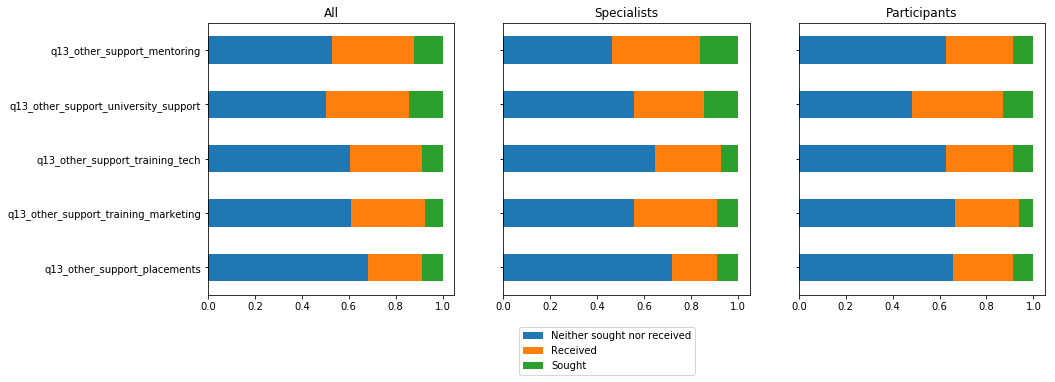

In [995]:
#Now we want to visualise the extent to which immersive companies access different types of 
#support. This will be chart that gets, for each type of company (specialis, participant etc.) their
#engagement with different types of programmes,.

skills_variables = [x for x in mtm.columns if 'q13_' in x]


#Creatye a financial ranking
skills_ranked = pd.concat(
    [extract_policy_engagement(
        mtm,x) for x in skills_variables],axis=1).T.sort_values('Received',ascending=False).index[::-1]


#Plot
fig,ax = plt.subplots(figsize=(15,5),ncols=3,sharey=True)

#This creates a list with 3 crosstabs
skills_engs = [pd.concat([extract_policy_engagement(
    mtm.loc[[x in function for x in mtm.function]],x) for x in skills_variables],
                         axis=1).T.loc[skills_ranked] for function in [['participant','specialist','allied'],
                                                                       ['specialist'],['participant']]]

#And then we plot them
[x[0].plot.barh(stacked=True,ax=ax[num],title=x[1],
             legend = True if num==0 else False) for num,x in enumerate(zip(
    skills_engs,['All','Specialists','Participants']))]

#Move the legend
ax[0].legend(bbox_to_anchor=[2,-0.1])

In [996]:
for x,y in zip(skills_engs,['all','spec','part']):
    
    print(y.upper())
    
    out = x.sort_values('Received',ascending=False)
    out['success_rate'] = x['Received']/(x['Sought']+x['Received'])
    print(out)
    print('\n')
    print('\n')

ALL
                                      Neither sought nor received  Received  \
q13_other_support_university_support                     0.503788  0.352273   
q13_other_support_mentoring                              0.530303  0.348485   
q13_other_support_training_marketing                     0.609848  0.314394   
q13_other_support_training_tech                          0.606061  0.306818   
q13_other_support_placements                             0.681818  0.231061   

                                        Sought  success_rate  
q13_other_support_university_support  0.143939      0.709924  
q13_other_support_mentoring           0.121212      0.741935  
q13_other_support_training_marketing  0.075758      0.805825  
q13_other_support_training_tech       0.087121      0.778846  
q13_other_support_placements          0.087121      0.726190  




SPEC
                                      Neither sought nor received  Received  \
q13_other_support_mentoring                            

### Meetup analysis

In [999]:
from gensim.models.word2vec import Word2Vec
from geopandas.geoseries import *


In [1283]:
#Load the data
with open(ext_data+'/meetup_groups.json','r') as infile:
    groups = json.load(infile)
    
#Load the data
with open(ext_data+'/meetup_groups_members.json','r') as infile:
    members = json.load(infile)
    
    
with open(ext_data+'/meetup_groups_events.json','r') as infile:
    events = json.load(infile)
    
#Focus on UK groups
uk = [x for x in groups if x['country']=='GB']

print(len(uk))

print(np.sum([x['members'] for x in uk]))


#There are 1.4m people here. Let's look for the ones in UK groups
#This is a list of group ids
uk_groups_ids = set([x['id'] for x in uk])

#Extract users with mexican ids
uk_users = [x for x in members if x['group_id'] in uk_groups_ids]


#Create group membership lists
#First we create a container for members
group_memberships = {x:[] for x in set([x['group_id'] for x in uk_users])} 

#Then we go through each member and append them to each group
for user in uk_users:
    group_memberships[user['group_id']].append(user['member_id'])

7278
5562226.0


In [1285]:
keyword_list = {x['id']:[top['urlkey'] for top in x['topics']] for x in uk}

model = Word2Vec([x for x in keyword_list.values()])

print(model.most_similar('virtual-reality',topn=20))
print('\n')
print(model.most_similar('augmented-reality',topn=20))
print('\n')
print(model.most_similar('hololens',topn=20))

[('augmented-reality', 0.9982848763465881), ('apis', 0.9977253079414368), ('diy', 0.9968148469924927), ('3d-printing', 0.9965935945510864), ('makerspaces', 0.9963615536689758), ('social-coding', 0.9961421489715576), ('whitehat', 0.9957137107849121), ('tech-talks', 0.9951271414756775), ('microcontroller', 0.9950838088989258), ('coders', 0.9943481087684631), ('it-professionals', 0.9942165613174438), ('makers', 0.9941993951797485), ('smart-home', 0.9933088421821594), ('hardware', 0.9929772019386292), ('google-cloud-platform', 0.9927932024002075), ('entarchitecture', 0.9927791953086853), ('robots', 0.9923864006996155), ('hardware-engineering', 0.9920694231987), ('designers', 0.992021381855011), ('web-programmers', 0.9914961457252502)]


[('virtual-reality', 0.9982849359512329), ('makers', 0.9968271255493164), ('apis', 0.9964658617973328), ('makerspaces', 0.9959656000137329), ('microcontroller', 0.9954537749290466), ('social-coding', 0.9953845739364624), ('diy', 0.9950246810913086), ('white

### LDA analysis

In [1286]:
class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised_filtered = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
        
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

In [1287]:
#Extract test topics

from gensim import corpora, models

mu_df = pd.DataFrame({'id':list(keyword_list.keys()),'keywords':list(keyword_list.values())})

test = LdaPipeline(mu_df['keywords']).filter(3).process().fit_lda(
    num_topics=100,passes=20,iterations=150).predict_topics()


#We extract the topic mixes to label and classify as creative or non-creative.
#We'll do that by hand in excel
topic_mixes = pd.DataFrame(test.lda_topics[:100])

topic_mixes.columns=['topic_number','topic_mix']

topic_mixes.to_csv(top+'/references/{date}_topic_mix_for_labelling_70.csv'.format(date=today_str),index=False)


In [1451]:
#The VR topic is number 43.

imm_ids = {x for x,y in zip(mu_df['id'],test.predicted_df.idxmax(axis=1)) if y==43}

#Also identify the groups with some immersive interests
#We combine the ids and the predictions and extract the ids with immersive probability above 0
imm_merged = pd.concat([mu_df['id'],test.predicted_df],axis=1)

imm_id_broad = imms_merged.loc[imms_merged[43]>0,'id'] 

#Extract the ids
imm_ids_broad_tech = {x['id'] for x in uk if (x['category_name'].lower()=='tech') & (x['id']in set(
    imm_id_broad)-set(imm_ids))}


In [1452]:
#Find immersive groups
#imm_ids = [k for k,v in keyword_list.items() if any(x in v for x in ['virtual-reality','augmented-reality','mixed_reality'])]

#imm_groups = [x for x in uk if x['id'] in imm_ids]

In [1485]:
#Activity trends
#Key variables for the dataframe
uk_df = pd.concat([pd.DataFrame({'name':x['name'],
                                        'city':x['city'],'category':x['category_name'],
                                        'created':x['created'],
                                        'lat':x['lat'],
                                        'lon':x['lon'],'description':x['description']},
                                       index=[x['id']]) for x in uk]).reset_index(drop=False)

#Add a list with topics
uk_df['keyword_list'] = [[top['urlkey'] for top in x['topics']] for x in uk]


#Add the list of members
uk_df['member_list'] = [group_memberships[x] if x in group_memberships.keys() else [] 
                                for x in uk_df['index']]

uk_df['member_n'] = [len(x) for x in uk_df['member_list']]

#And now get the year the meetup was created from the timestamp. NB we divide by 1000 to go from miliseconds
#to seconds
uk_df['year'] = [datetime.datetime.fromtimestamp(x/1000).year for x in uk_df['created']]

uk_df['imm'] = [x in imm_ids for x in uk_df['index']]

uk_df['imm_broad'] = [x in imm_ids_broad_tech for x in uk_df['index']]

#What does it look like?
uk_df.head()

uk_df = uk_df.loc[[x.lower()=='tech' for x in uk_df.category]]

uk_tech = [x for x in uk if x['id'] in set(uk_df['index'])]


In [1497]:
uk_df.loc[uk_df.imm==True]

pd.crosstab(uk_df.year,uk_df.imm)

imm,False,True
year,,
2002,1,0
2006,2,0
2007,7,0
2008,13,0
2009,27,0
2010,53,0
2011,78,0
2012,138,1
2013,202,2


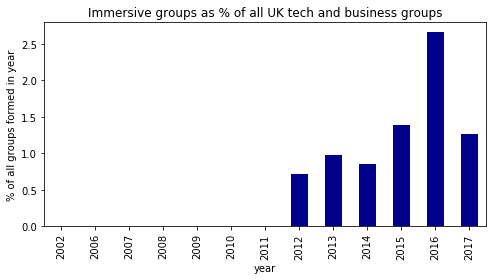

In [1498]:
#Plot activity
fig,ax = plt.subplots(figsize=(7,4))

imm_activity = pd.crosstab(uk_df.year,uk_df.imm,normalize=0).apply(lambda x: 100*x/x.sum(),axis=1)[True]
imm_activity.plot.bar(color='darkblue',ax=ax)

ax.set_title('Immersive groups as % of all UK tech and business groups')
ax.set_ylabel('% of all groups formed in year')

save_fig('immersive_meetups')

In [1299]:
#100*uk_df[uk_df.year>2015]['imm'].value_counts()/uk_df[uk_df.year>2015]['imm'].value_counts().sum()
#Now get the events

#We create a dataframe with the event data
events_df = pd.concat([pd.DataFrame({'time':x['event_time'],
                         'attendees':x['event_yes_rsvp_count'],
                         'group_id':x['group_id'],
                         'is_immersive':x['group_id'] in imm_ids},index=[num]) for num,x in enumerate(
    events)],axis=0)

#We will need to convert dates and add locations
events_df['year'] = [datetime.datetime.fromtimestamp(x/1000).year for x in events_df['time']]

In [1500]:
events_df['date'] = [datetime.datetime.fromtimestamp(x/1000) for x in events_df['time']]

#events_df['date'].value_counts().plot()

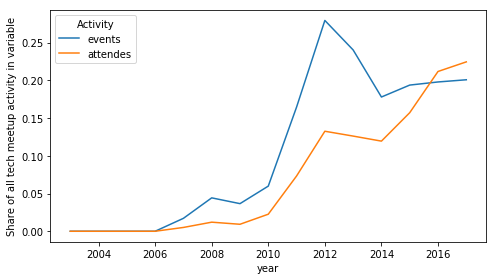

In [1499]:
#Now look at activity

imm_events = pd.crosstab(events_df['year'],events_df['is_immersive'])
imm_events['share_events'] = 100*imm_events[True]/imm_events.sum(axis=1)

imm_attendees = pd.pivot_table(
    events_df.groupby(['year','is_immersive'])['attendees'].sum().reset_index(drop=False),
    index='year',columns='is_immersive',values='attendees').fillna(0)

imm_attendees['share_attendees'] = 100*imm_attendees[True]/imm_attendees.sum(axis=1)

imm_time = pd.concat([imm_events['share_events'],imm_attendees['share_attendees']],axis=1)

fig,ax = plt.subplots(figsize=(7,4))

pd.rolling_mean(imm_time,window=2).plot(ax=ax)

ax.legend(labels=['events','attendes'],title='Activity',loc='upper left')

ax.set_ylabel('Share of all tech meetup activity in variable')

save_fig('meetup_events')

In [1501]:
imm_events[imm_events.index>2010].sum()/imm_events.sum()

imm_attendees[imm_attendees.index>2010].sum()/imm_attendees.sum()

is_immersive
False              0.915490
True               0.988494
share_attendees    0.941798
dtype: float64

In [1502]:
uk_df.groupby('imm')['member_list'].apply(lambda x: len(set([val for el in x for val in el])))
uk_df.groupby('imm_broad')['member_list'].apply(lambda x: len(set([val for el in x for val in el])))

imm_broad
False    241436
True       7031
Name: member_list, dtype: int64

In [1503]:
#Top 10 locations
uk_df.loc[uk_df['imm']==True,:].sort_values('member_n',ascending=False)[['name','city','member_n']][:15]

,name,city,member_n
4811,Mixed Reality London,London,217
6036,SouthWest VR,Bristol,201
6251,SWARVR – South West AR / VR,Bristol,172
2995,Investors in VR,London,167
1076,Cambridge Virtual Reality Meetup,Cambridge,155
4810,Mixed Reality Experience Playground - London,Greater London,154
6915,Virtual and Augmented Reality for Sports,London,127
335,Augmenting Reality,London,108
3770,London Hololens User Group,London,105
5294,in_collusion: Peterborough arts & technology m...,Peterborough,102


In [1504]:
#TTWA poly_2

ttwa_reproject = ttwa_shp.copy()

ttwa_reproject.crs

ttwa_wgs = ttwa_reproject.to_crs(epsg=4326)

In [1505]:
# Geocode

def point_in_poly(point,poly):
    '''
    This function checks if a point is inside a polygon and returns the result
    
    
    '''
    
    result = poly.contains(point)
    
    return(result)

#Everything

#ttwa_poly.reset_index(drop=False,inplace=True)

#This turns each meetup lat/lon into a geographical point we can search for in a polygon
meetup_geo_points = [(x['id'],Point(x['lon'],x['lat'])) for x in uk_tech]

#This container stores the states
cont = []

for point in [x[1] for x in meetup_geo_points]:
    
    #Applies the function above
    result = [point_in_poly(point,ttwa_wgs.loc[num,'geometry']) for num in np.arange(len(ttwa_wgs))]
    
    #Finds the state name that contains the point
    try:
        name = [x for x,y in zip(ttwa_wgs['TTWA11NM'],result) if y==True][0]
    
    #We had a problem with one of them
    except:
        name = np.nan
    
    #Returns all contents
    cont.append(name)


In [1506]:
uk_df['ttwa_name'] = cont

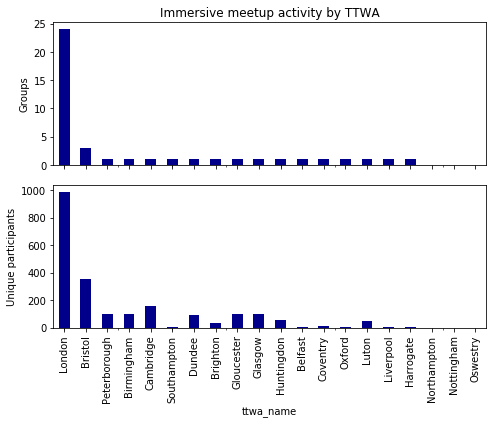

In [1507]:
#Top 15 places.

top_15_places = pd.crosstab(uk_df['ttwa_name'],uk_df['imm']).sort_values(True,ascending=False)[True][:20]

top_15_empl = uk_df.loc[uk_df.imm==True].groupby('ttwa_name')['member_list'].apply(
    lambda x: len(set([val for el in x for val in el])))[top_15_places.index]


fig,ax = plt.subplots(figsize=(7,6),nrows=2,sharex=True)


top_15_places.plot.bar(color='darkblue',ax=ax[0])
top_15_empl.plot.bar(color='darkblue',ax=ax[1])


ax[0].set_ylabel('Groups')
ax[1].set_ylabel('Unique participants')

ax[0].set_title('Immersive meetup activity by TTWA')


save_fig('meetup_places')


In [1509]:
uk_df.loc[uk_df.imm==True].groupby('ttwa_name')['member_list'].apply(
    lambda x: len(set([val for el in x for val in el]))).sort_values(ascending=False)

ttwa_name
London          987
Bristol         356
Cambridge       155
Peterborough    102
Glasgow          97
Gloucester       96
Birmingham       96
Dundee           95
Huntingdon       58
Luton            45
Brighton         35
Coventry         10
Belfast           7
Oxford            7
Liverpool         4
Southampton       3
Harrogate         2
Name: member_list, dtype: int64

In [1510]:
writer = pd.ExcelWriter(ext_data+'/oecd_files.xls')

uk_df.iloc[np.random.randint(0,len(uk_df),100),:][
    ['name','description','keyword_list','city','year','member_n']].to_excel(
    writer,sheet_name='meetup_sample',index=False)

glai.iloc[np.random.randint(0,len(glai),100),:][
    ['Company Name','Description','Website','Locations']].to_excel(writer,sheet_name='glai_sample',
                                                                  index=False)

writer.save()

In [1492]:
#We want to create a network connecting communities.

#How is this going to work?
#We create for each TTWA a list with its members
ttwa_imm_members = uk_df.loc[uk_df.imm==True,:].groupby('ttwa_name')['member_list']


In [1511]:
uk_df.head()

,index,category,city,created,description,lat,lon,name,keyword_list,member_list,member_n,year,imm,imm_broad,ttwa_name
0,22021080.0,tech,London,1.485041e+12,<p>AI and Cognitive systems process knowledge ...,51.53,-0.08,CAIDI: Cognitive & AI Data Infrastructure,"[ai, opensource, databasepro, softwaredev, dat...","[142610, 1821827, 2135982, 2146089, 2923961, 3...",893,2017,False,False,London
5,23144528.0,tech,London,1.491322e+12,<p>IWOMM is the technology club of the 101 Way...,51.52,-0.10,IWOMM,"[java, opensource, softwaredev, xp, scrum, tec...",[13450856],1,2017,False,False,London
7,24763255.0,tech,Edinburgh,1.498846e+12,<p>What is 12min.me?</p>\n<p>We are bringing t...,55.95,-3.22,12min.me Edinburgh,"[singles, newintown, beer, self-improvement, s...","[5076757, 8913625, 9528642, 10028279, 11235648...",77,2017,False,False,Edinburgh
11,26556190.0,tech,London,1.510330e+12,"<p>Tin Foil Hats, Memory Injections and Bad Ra...",51.52,-0.10,Cybersecurity with Countercept,"[opensource, prodev, newtech, web, hacking, st...","[9540597, 10225432, 12186731, 13289698, 133621...",45,2017,False,False,London
19,12332152.0,tech,Edinburgh,1.390310e+12,<p><b>Total 3D Experience</b></p>\n<p><b>3D Pr...,55.95,-3.17,3D Printing Edinburgh,"[newtech, 3d-modeling, reprap, 3d-artists, 3d-...","[4510240, 4876726, 5400647, 6220408, 8433402, ...",81,2014,False,False,Edinburgh
